In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(scales)
library(NICHES)
library(stringr)
library(reshape2)
library(cowplot)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
options(warn=-1)
set.seed(42)

In [3]:
female_24weeks_rds <- readRDS('../combined_female_24weeks.rds')

In [4]:
Idents(female_24weeks_rds) <- female_24weeks_rds@meta.data$celltype_broad

In [5]:
female_24weeks_rds

An object of class Seurat 
20743 features across 16055 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [6]:
#write.csv(male_8weeks_rds@meta.data[c('sample_type', 'celltype_broad')],'adjacency_metadata.csv')

In [7]:
data.list <- SplitObject(female_24weeks_rds, split.by="sample_type")

In [8]:
data.list <- lapply(X = data.list, FUN = function(x) {
    x <- NormalizeData(x)
})

Normalizing layer: counts

Normalizing layer: counts



In [9]:
data.list[1]
data.list[2]

$taPVAT_Control_24W_F
An object of class Seurat 
20743 features across 7534 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


$taPVAT_HF_24W_F
An object of class Seurat 
20743 features across 8521 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


In [10]:
table(data.list[[1]]@meta.data['celltype_broad'])
table(data.list[[2]]@meta.data['celltype_broad'])

celltype_broad
       Adipocytes Endothelial_Cells       Fibroblasts      Immune_Cells 
             4387              1790               735               239 
Mesothelial_Cells    Neuronal_Cells         Pericytes              SMCs 
               56                11               273                43 

celltype_broad
       Adipocytes Endothelial_Cells       Fibroblasts      Immune_Cells 
             5416              1697               720               241 
Mesothelial_Cells    Neuronal_Cells         Pericytes              SMCs 
              112                23               281                31 

In [11]:
#for (i in 1:length(data.list)){
  #Idents(data.list[[i]]) <- data.list[[i]]$sample_type
  #data.list[[i]] <- subset(data.list[[i]],cells = WhichCells(data.list[[i]],downsample = max.cells))
#  Idents(data.list[[i]]) <- data.list[[i]]$celltype_broad
#}

In [12]:
# Run NICHES on each system and store/name the outputs
scc.list <- list()
for(i in 1:length(data.list)){
  print(i)
  scc.list[[i]] <- RunNICHES(data.list[[i]],
                             LR.database="fantom5",
                             species="mouse",
                             assay="RNA",
                             cell_types = "celltype_broad",
                             min.cells.per.ident=1,
                             min.cells.per.gene = 50,
                             meta.data.to.map = c('orig.ident','celltype_broad','sample_type'),
                             SystemToCell = T,
                             CellToCell = T,
                            #CellToNeighborhood = T,
                            #NeighborhoodToCell = T
                            )
}

names(scc.list) <- names(data.list)

[1] 1


Set cell types as Identity of object internally


 Subsetting to populations with greater than 1 cells


 Subsetting to genes expressed in greater than 50 cells


 7534 distinct cells from 8 celltypes to be analyzed


 Limiting ground truth to genes within dataset


 Mapping against 671 ground truth signaling mechanisms


 For sampling purposes, please make sure that the active Identity of the input seurat object corresponds to cell types

Normalizing layer: counts


 18834 Cell-To-Cell edges computed, sampling 64 distinct VectorTypes, out of 64 total possible

Normalizing layer: counts


 7534 System-To-Cell edges were computed, across 8 cell types



[1] 2


Set cell types as Identity of object internally


 Subsetting to populations with greater than 1 cells


 Subsetting to genes expressed in greater than 50 cells


 8521 distinct cells from 8 celltypes to be analyzed


 Limiting ground truth to genes within dataset


 Mapping against 692 ground truth signaling mechanisms


 For sampling purposes, please make sure that the active Identity of the input seurat object corresponds to cell types

Normalizing layer: counts


 20223 Cell-To-Cell edges computed, sampling 64 distinct VectorTypes, out of 64 total possible

Normalizing layer: counts


 8521 System-To-Cell edges were computed, across 8 cell types



In [13]:
temp.list <- list()
for(i in 1:length(scc.list)){
temp.list[[i]] <- scc.list[[i]]$CellToCell 
temp.list[[i]]$Condition <- names(scc.list)[i] 
}

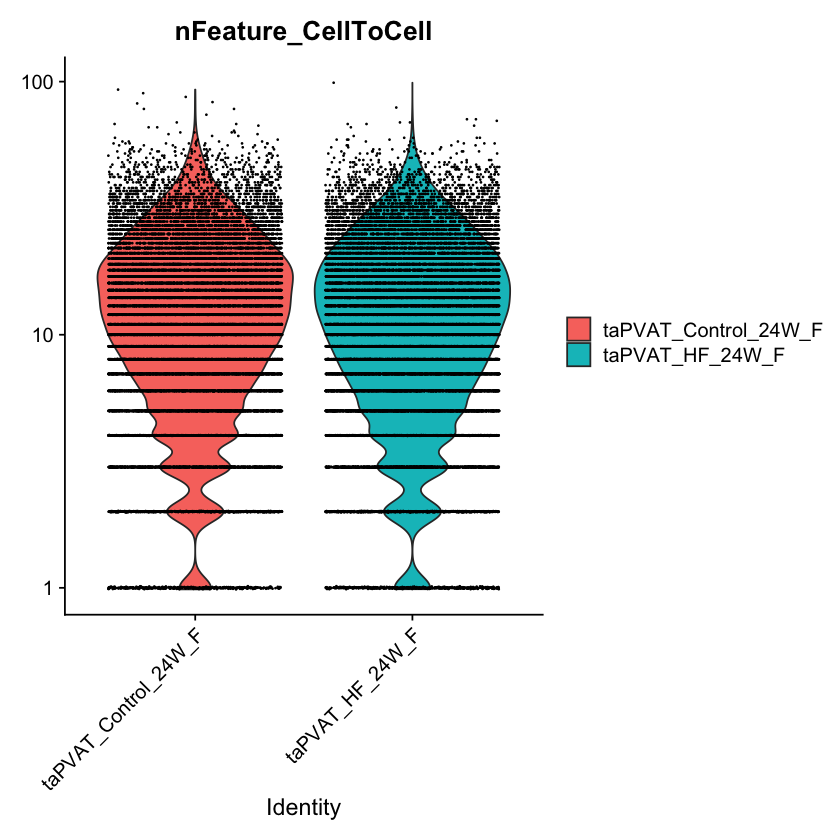

In [14]:
# Merge together
scc.merge <- merge(temp.list[[1]],temp.list[2])

# Clean up low-information crosses (connectivity data can be very sparse)
VlnPlot(scc.merge,features = 'nFeature_CellToCell',group.by = 'Condition',pt.size=0.1,log = T)

In [15]:
scc.sub <- subset(scc.merge,nFeature_CellToCell > 5) # Requesting at least 5 distinct ligand-receptor interactions between two cells

In [16]:
unique(scc.sub$VectorType)

[1] "Adipocytes—Adipocytes"               "Adipocytes—Endothelial_Cells"       
 [3] "Adipocytes—Immune_Cells"             "Adipocytes—Pericytes"               
 [5] "Adipocytes—Fibroblasts"              "Adipocytes—Mesothelial_Cells"       
 [7] "Adipocytes—Neuronal_Cells"           "Adipocytes—SMCs"                    
 [9] "Endothelial_Cells—Adipocytes"        "Endothelial_Cells—Endothelial_Cells"
[11] "Endothelial_Cells—Immune_Cells"      "Endothelial_Cells—Pericytes"        
[13] "Endothelial_Cells—Fibroblasts"       "Endothelial_Cells—Mesothelial_Cells"
[15] "Endothelial_Cells—Neuronal_Cells"    "Endothelial_Cells—SMCs"             
[17] "Immune_Cells—Adipocytes"             "Immune_Cells—Endothelial_Cells"     
[19] "Immune_Cells—Immune_Cells"           "Immune_Cells—Pericytes"             
[21] "Immune_Cells—Fibroblasts"            "Immune_Cells—Mesothelial_Cells"     
[23] "Immune_Cells—Neuronal_Cells"         "Immune_Cells—SMCs"                  
[25] "Pericytes—Adipocytes"                "Pericytes—Endothelial_Cells"        
[27] "Pericytes—Immune_Cells"              "Pericytes—Pericytes"                
[29] "Pericytes—Fibroblasts"               "Pericytes—Mesothelial_Cells"        
[31] "Pericytes—Neuronal_Cells"            "Pericytes—SMCs"                     
[33] "Fibroblasts—Adipocytes"              "Fibroblasts—Endothelial_Cells"      
[35] "Fibroblasts—Immune_Cells"            "Fibroblasts—Pericytes"              
[37] "Fibroblasts—Fibroblasts"             "Fibroblasts—Mesothelial_Cells"      
[39] "Fibroblasts—Neuronal_Cells"          "Fibroblasts—SMCs"                   
[41] "Mesothelial_Cells—Adipocytes"        "Mesothelial_Cells—Endothelial_Cells"
[43] "Mesothelial_Cells—Immune_Cells"      "Mesothelial_Cells—Pericytes"        
[45] "Mesothelial_Cells—Fibroblasts"       "Mesothelial_Cells—Mesothelial_Cells"
[47] "Mesothelial_Cells—Neuronal_Cells"    "Mesothelial_Cells—SMCs"             
[49] "Neuronal_Cells—Adipocytes"           "Neuronal_Cells—Endothelial_Cells"   
[51] "Neuronal_Cells—Immune_Cells"         "Neuronal_Cells—Pericytes"           
[53] "Neuronal_Cells—Fibroblasts"          "Neuronal_Cells—Mesothelial_Cells"   
[55] "Neuronal_Cells—Neuronal_Cells"       "Neuronal_Cells—SMCs"                
[57] "SMCs—Adipocytes"                     "SMCs—Endothelial_Cells"             
[59] "SMCs—Immune_Cells"                   "SMCs—Pericytes"                     
[61] "SMCs—Fibroblasts"                    "SMCs—Mesothelial_Cells"             
[63] "SMCs—Neuronal_Cells"                 "SMCs—SMCs"

In [17]:
#as.data.frame(GetAssayData(scc.list$taPVAT_Control_8W_M$CellToCell, slot = "counts"))

Centering and scaling data matrix

Finding variable features for layer data.1

Finding variable features for layer data.2

PC_ 1 
Positive:  Lama2—Itgb1, Col6a2—Itgb1, Col3a1—Itgb1, Col5a2—Itgb1, Fbn1—Itgb1, Col6a1—Itgb1, Col6a3—Itgb1, Lama2—Itga1, Col5a1—Itgb1, Col1a2—Itgb1 
	   Col4a4—Itgb1, Col6a2—Itga1, Adam12—Itgb1, Col6a1—Itga1, Col5a2—Itga1, Col1a1—Itgb1, Col4a1—Itgb1, Col6a3—Itga1, Lamc1—Itgb1, Col4a3—Itgb1 
	   Angpt1—Itgb1, Lama4—Itgb1, Col1a2—Itga1, Nid1—Itgb1, Col4a4—Itga1, Col5a1—Itga1, Col1a1—Itga1, Col4a3—Itga1, Lama2—Itga6, Hspg2—Itgb1 
Negative:  Vegfa—Nrp1, Sorbs1—Insr, Nrg4—Erbb4, Lpl—Lrp1, Gnas—Adrb3, Gnas—Adcy9, Fgf1—Nrp1, Vegfa—Nrp2, Nampt—Insr, Adipoq—Adipor2 
	   Vegfa—Itgav, Fgf1—Fgfr1, Psap—Lrp1, Hspg2—Ptprs, Sorbs1—Itgb5, Adam17—Erbb4, Psap—Sort1, Gnas—Adora1, Vegfb—Nrp1, Sorbs1—Itga1 
	   Lpl—Vldlr, Nrg2—Erbb4, Gnas—Tshr, Farp2—Plxna2, Fgf1—Fgfr2, Egf—Erbb4, Lama4—Itgav, Fgf1—Fgfrl1, Vegfa—Sirpa, Adipoq—Adipor1 
PC_ 2 
Positive:  Lpl—Lrp1, Vegfa—Itgb1, Lama4

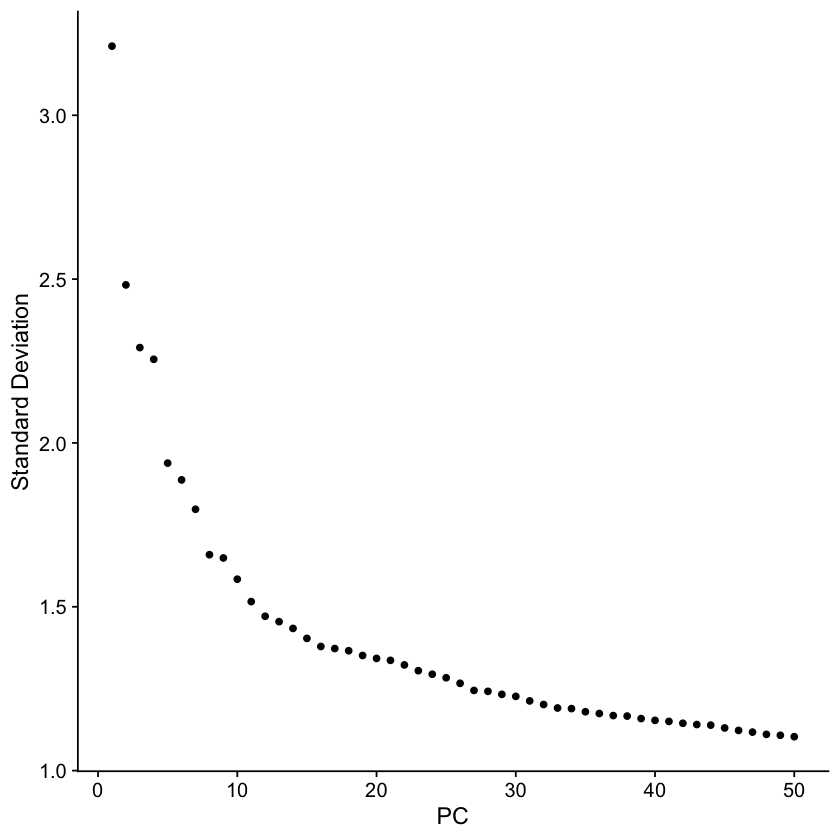

In [18]:
# Perform initial visualization
scc.sub <- ScaleData(scc.sub)
scc.sub <- FindVariableFeatures(scc.sub,selection.method = "disp")
scc.sub <- RunPCA(scc.sub,npcs = 50)
ElbowPlot(scc.sub,ndim=50)

22:11:28 UMAP embedding parameters a = 0.9922 b = 1.112

22:11:28 Read 29068 rows and found 25 numeric columns

22:11:28 Using Annoy for neighbor search, n_neighbors = 30

22:11:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:11:30 Writing NN index file to temp file /var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T//RtmpHMX3wp/file15a934a35f7

22:11:30 Searching Annoy index using 1 thread, search_k = 3000

22:11:38 Annoy recall = 100%

22:11:38 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:11:40 Initializing from normalized Laplacian + noise (using RSpectra)

22:11:40 Commencing optimization for 200 epochs, with 1250348 positive edges

22:12:05 Optimization finished



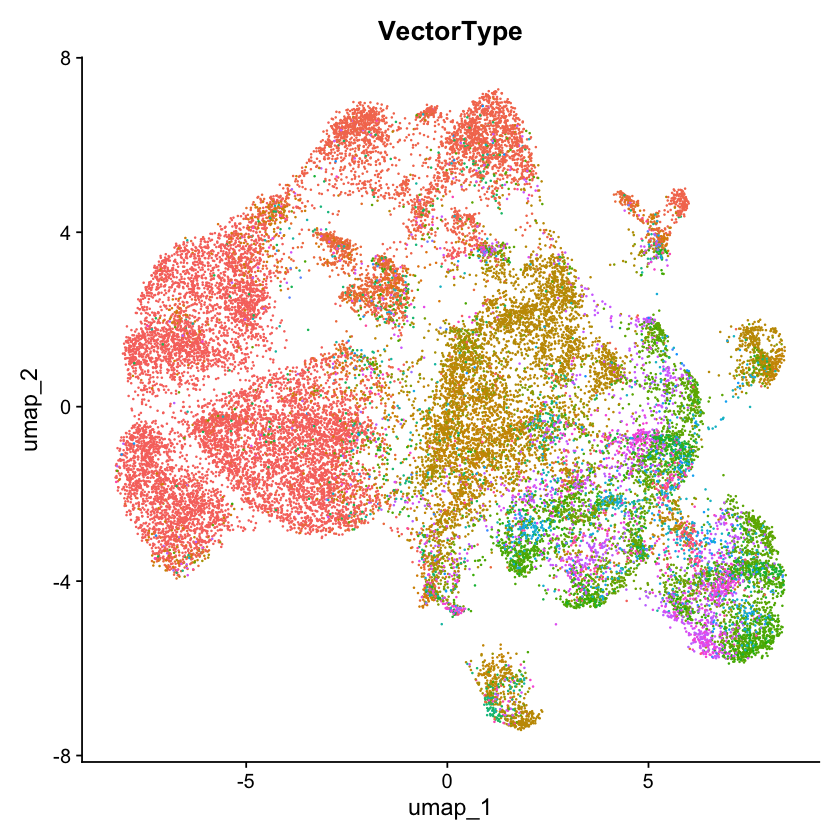

In [19]:
scc.sub <- RunUMAP(scc.sub,dims = 1:25)
DimPlot(scc.sub,group.by = 'VectorType')+NoLegend()

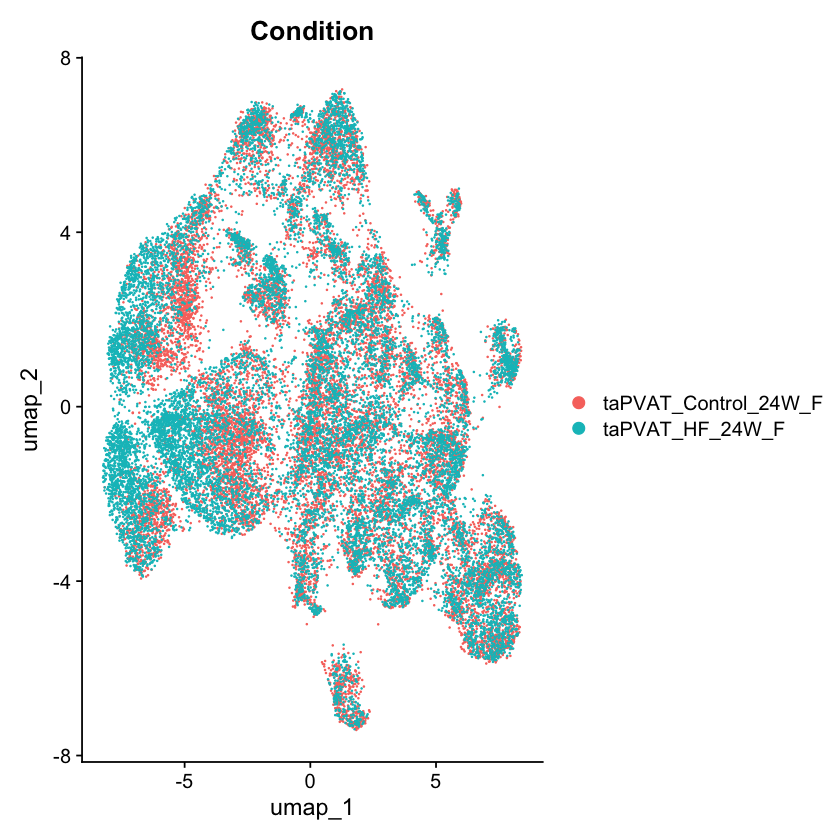

In [20]:
DimPlot(scc.sub,group.by = 'Condition')

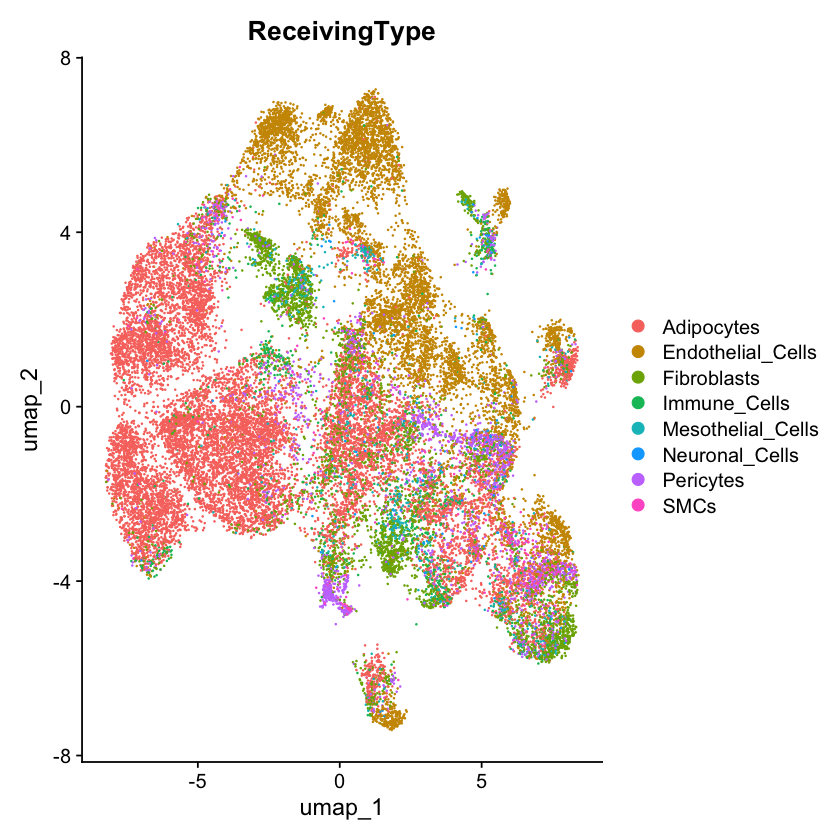

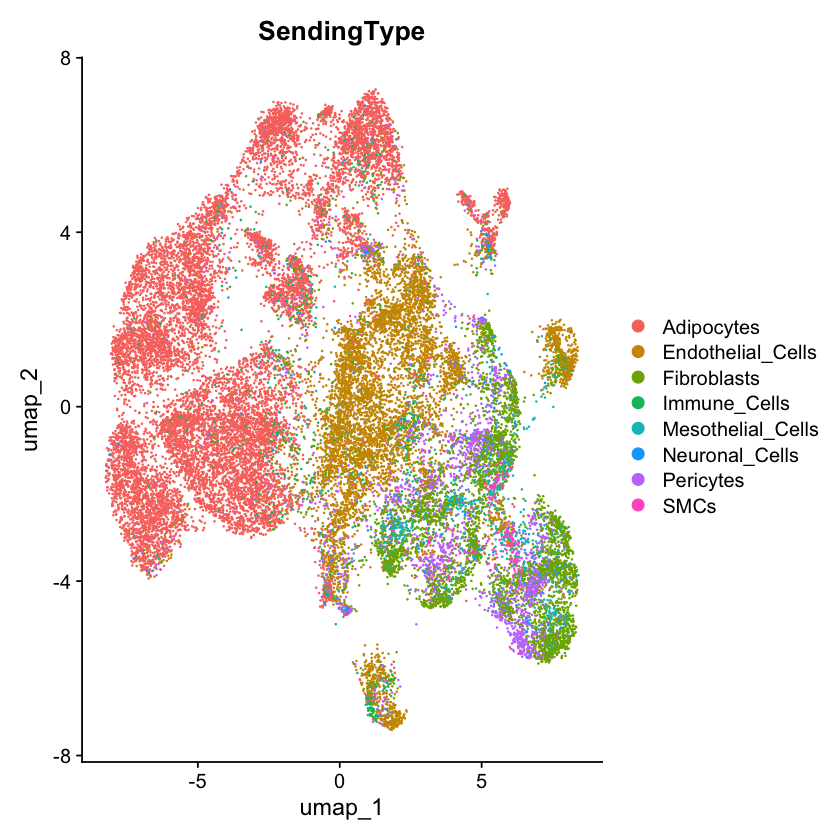

In [21]:
DimPlot(scc.sub,group.by = 'ReceivingType')
DimPlot(scc.sub,group.by = 'SendingType')

In [22]:
table(scc.sub@meta.data$VectorType)


              Adipocytes—Adipocytes        Adipocytes—Endothelial_Cells 
                               8720                                2994 
             Adipocytes—Fibroblasts             Adipocytes—Immune_Cells 
                               1122                                 250 
       Adipocytes—Mesothelial_Cells           Adipocytes—Neuronal_Cells 
                                114                                  16 
               Adipocytes—Pericytes                     Adipocytes—SMCs 
                                396                                  57 
       Endothelial_Cells—Adipocytes Endothelial_Cells—Endothelial_Cells 
                               2721                                2558 
      Endothelial_Cells—Fibroblasts      Endothelial_Cells—Immune_Cells 
                                899                                 167 
Endothelial_Cells—Mesothelial_Cells    Endothelial_Cells—Neuronal_Cells 
                                103               

In [23]:
scc.sub@assays$CellToCell

Assay (v5) data with 719 features for 29068 cells
Top 10 variable features:
 Vegfa—Nrp1, Col4a1—Itgb1, Vegfa—Flt1, Sema3c—Nrp1, Vegfa—Egfr,
Nxph1—Nrxn1, Lama2—Itgb1, Lama2—Itgb4, Col4a1—Itga1, Reln—Itgb1 
Layers:
 counts.1, counts.2, data.1, data.2, scale.data 

In [24]:
rownames(GetAssayData(scc.sub, assay = "CellToCell", slot = "scale.data"))


[1] "Ace—Bdkrb2"        "Adam10—Axl"        "Adam10—Epha3"     
  [4] "Adam12—Itga9"      "Adam12—Itgb1"      "Adam12—Sdc4"      
  [7] "Adam15—Itga5"      "Adam15—Itga9"      "Adam15—Itgav"     
 [10] "Adam15—Itgb1"      "Adam15—Itgb3"      "Adam17—Erbb4"     
 [13] "Adam17—Itga5"      "Adam17—Itgb1"      "Adam17—Notch1"    
 [16] "Adam23—Itga5"      "Adam23—Itgb3"      "Adam9—Itga3"      
 [19] "Adam9—Itga6"       "Adam9—Itgav"       "Adam9—Itgb1"      
 [22] "Adam9—Itgb5"       "Adipoq—Adipor1"    "Adipoq—Adipor2"   
 [25] "Adm—Calcrl"        "Agrn—Lrp4"         "Angpt1—Itga5"     
 [28] "Angpt1—Itgb1"      "Angpt1—Tek"        "Angpt1—Tie1"      
 [31] "Angpt2—Tek"        "Angpt2—Tie1"       "Angptl1—Tek"      
 [34] "Angptl2—Tie1"      "Angptl4—Tie1"      "Anxa1—Dysf"       
 [37] "Anxa1—Egfr"        "Apoe—Ldlr"         "Apoe—Lrp1"        
 [40] "Apoe—Lrp5"         "Apoe—Scarb1"       "Apoe—Sorl1"       
 [43] "Apoe—Vldlr"        "App—Cav1"          "App—Cd74"         
 [46] "App—Lrp1"          "App—Ncstn"         "App—Slc45a3"      
 [49] "App—Tnfrsf21"      "B2m—Tfrc"          "Bgn—Ly96"         
 [52] "Bgn—Tlr4"          "Bmp4—Acvr1"        "Bmp4—Acvr2a"      
 [55] "Bmp4—Acvr2b"       "Bmp4—Bmpr1a"       "Bmp4—Bmpr1b"      
 [58] "Bmp4—Bmpr2"        "Bmp5—Acvr1"        "Bmp5—Acvr2a"      
 [61] "Bmp5—Acvr2b"       "Bmp5—Bmpr1a"       "Bmp5—Bmpr1b"      
 [64] "Bmp5—Bmpr2"        "Bmp6—Acvr1"        "Bmp6—Acvr2a"      
 [67] "Bmp6—Acvr2b"       "Bmp6—Bmpr1a"       "Bmp6—Bmpr1b"      
 [70] "Bmp6—Bmpr2"        "Btc—Egfr"          "Btc—Erbb4"        
 [73] "C4b—Cd46"          "Calm1—Abca1"       "Calm1—Adcyap1r1"  
 [76] "Calm1—Cacna1c"     "Calm1—Egfr"        "Calm1—Fas"        
 [79] "Calm1—Glp2r"       "Calm1—Insr"        "Calm1—Kcnq1"      
 [82] "Calm1—Kcnq5"       "Calm1—Mylk"        "Calm1—Pde1a"      
 [85] "Calm1—Pde1c"       "Calm1—Ptpra"       "Calm1—Sctr"       
 [88] "Calm1—Trpc3"       "Calm2—Abca1"       "Calm2—Egfr"       
 [91] "Calm2—Insr"        "Calm2—Kcnq1"       "Calm2—Kcnq5"      
 [94] "Calm2—Mylk"        "Calm2—Pde1a"       "Calm2—Pde1c"      
 [97] "Calr—Itga2b"       "Calr—Itga3"        "Calr—Itgav"       
[100] "Calr—Lrp1"         "Calr—Scarf1"       "Calr—Tshr"        
[103] "Ccl27—Ackr2"       "Clcf1—Cntfr"       "Clcf1—Crlf1"      
[106] "Clcf1—Il6st"       "Clcf1—Lifr"        "Cntf—Cntfr"       
[109] "Cntf—Il6st"        "Cntf—Lifr"         "Cntn4—Ptprg"      
[112] "Col14a1—Cd44"      "Col18a1—Gpc4"      "Col18a1—Itga5"    
[115] "Col18a1—Itgb1"     "Col18a1—Kdr"       "Col1a1—Cd44"      
[118] "Col1a1—Cd93"       "Col1a1—Ddr1"       "Col1a1—Ddr2"      
[121] "Col1a1—Flt4"       "Col1a1—Itga1"      "Col1a1—Itga11"    
[124] "Col1a1—Itga5"      "Col1a1—Itgav"      "Col1a1—Itgb1"     
[127] "Col1a2—Cd44"       "Col1a2—Cd93"       "Col1a2—Flt4"      
[130] "Col1a2—Itga1"      "Col1a2—Itga11"     "Col1a2—Itga2b"    
[133] "Col1a2—Itgav"      "Col1a2—Itgb1"      "Col1a2—Itgb3"     
[136] "Col3a1—Ddr1"       "Col3a1—Ddr2"       "Col3a1—Itgb1"     
[139] "Col4a1—Cd47"       "Col4a1—Cd93"       "Col4a1—Itga1"     
[142] "Col4a1—Itgav"      "Col4a1—Itgb1"      "Col4a1—Itgb8"     
[145] "Col4a2—Cd93"       "Col4a3—Cd47"       "Col4a3—Cd93"      
[148] "Col4a3—Itga1"      "Col4a3—Itgav"      "Col4a3—Itgb1"     
[151] "Col4a4—Cd47"       "Col4a4—Cd93"       "Col4a4—Itga1"     
[154] "Col4a4—Itgav"      "Col4a4—Itgb1"      "Col4a5—Cd47"      
[157] "Col4a5—Cd93"       "Col4a5—Itga1"      "Col4a5—Itgav"     
[160] "Col4a5—Itgb1"      "Col4a6—Cd47"       "Col4a6—Cd93"      
[163] "Col4a6—Itga1"      "Col4a6—Itgav"      "Col4a6—Itgb1"     
[166] "Col5a1—Itga1"      "Col5a1—Itgb1"      "Col5a1—Sdc3"      
[169] "Col5a2—Ddr1"       "Col5a2—Itga1"      "Col5a2—Itgb1"     
[172] "Col5a3—Sdc3"       "Col6a1—Itga1"      "Col6a1—Itga6"     
[175] "Col6a1—Itgb1"      "Col6a2—Itga1"      "Col6a2—Itgb1"     
[178] "Col6a3—Itga1"      "Col6a3—Itgb1"      "Col7a1—Itgb1"     
[181] "Col8a1—Itga1"      "Cp—Slc40a1"    

In [25]:

celltocell_heatmap <- function(VOI) {

    # Loop over VectorTypes of interest, subsetting those interactions, finding markers associated with the comparison of interest (stimulus vs control) and  create a heatmap of top markers:
results <- lapply(VOI, function(x){
 
  #subset
  subs <- subset(scc.sub, subset = VectorType == x)
  subs <- JoinLayers(subs, layers = c("data", "scale.data"))
  
  #print number of cells per condition
  print(paste0(x , ":  taPVAT_Control_24W_F:", sum(subs@meta.data$Condition == "taPVAT_Control_24W_F")))
  print(paste0(x , ":  taPVAT_HF_24W_F:", sum(subs@meta.data$Condition == "taPVAT_HF_24W_F")))
  
  #set idents
  Idents(subs) <- subs@meta.data$Condition
  
  #scale the subsetted data
  FindVariableFeatures(subs,assay='CellToCell',selection.method = "disp")
  ScaleData(subs, assay='CellToCell')
  
  #these are the features in the scaledata slot
  feats <- rownames(GetAssayData(subs, assay = "CellToCell", slot = "scale.data"))
  feats
  
  #find markers (here we use wilcox, but ROC and other tests can be used as well)
  markers <- FindAllMarkers(subs, features=feats, test.use = "wilcox",assay='CellToCell')
  
  #subset to top 10 markers per condition
  top10 <- markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
    
  list(subs = subs, top10 = top10)
  #Make a heatmap
  #plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top DE Mechanisms, CTRL vs STIM: ",x)
  
})
    return(results)
}

[1] "Fibroblasts—Adipocytes:  taPVAT_Control_24W_F:633"
[1] "Fibroblasts—Adipocytes:  taPVAT_HF_24W_F:631"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_24W_F

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster taPVAT_HF_24W_F



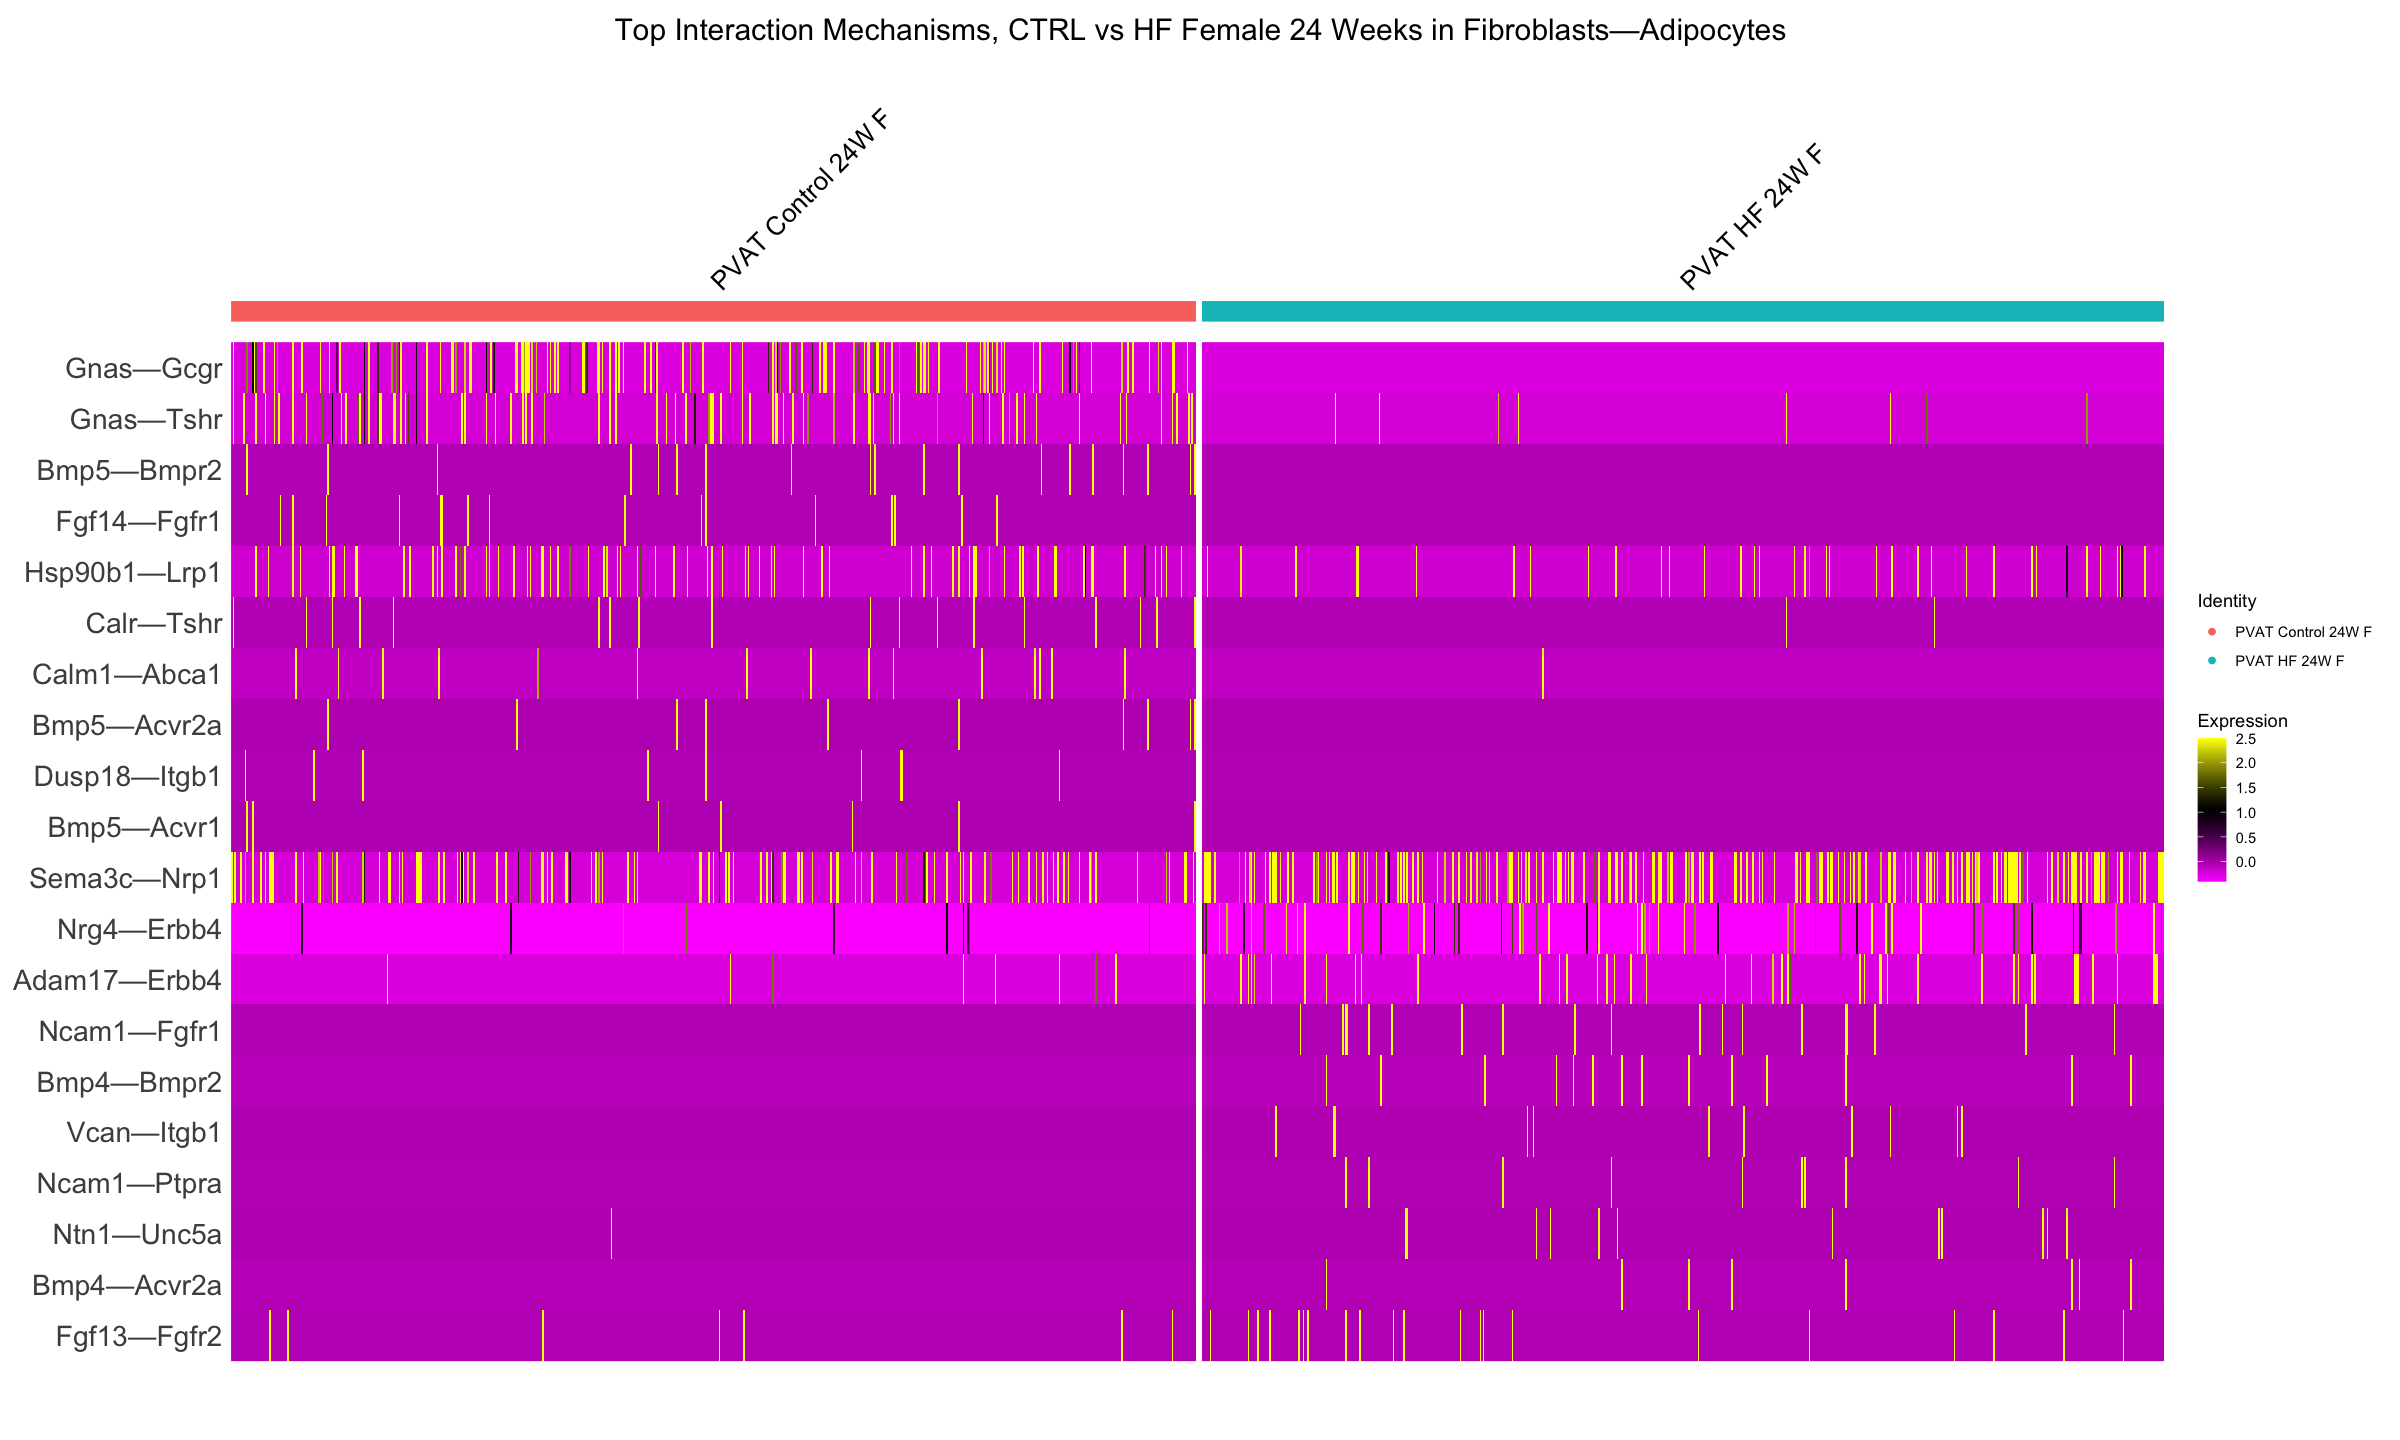

In [26]:
fibro_adipo <- celltocell_heatmap("Fibroblasts—Adipocytes")

options(repr.plot.width=20, repr.plot.height=12)
subs <- fibro_adipo[[1]]$subs
top10 <- fibro_adipo[[1]]$top10

Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_24W_F", "taPVAT_HF_24W_F"), 
                        labels = c("PVAT Control 24W F", "PVAT HF 24W F"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Female 24 Weeks in Fibroblasts—Adipocytes") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Female 24 Weeks in Fibroblasts—Adipocytes.pdf", plot = plot, width = 20, height = 12, dpi = 600)

[1] "Adipocytes—Fibroblasts:  taPVAT_Control_24W_F:586"
[1] "Adipocytes—Fibroblasts:  taPVAT_HF_24W_F:536"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_24W_F

Calculating cluster taPVAT_HF_24W_F



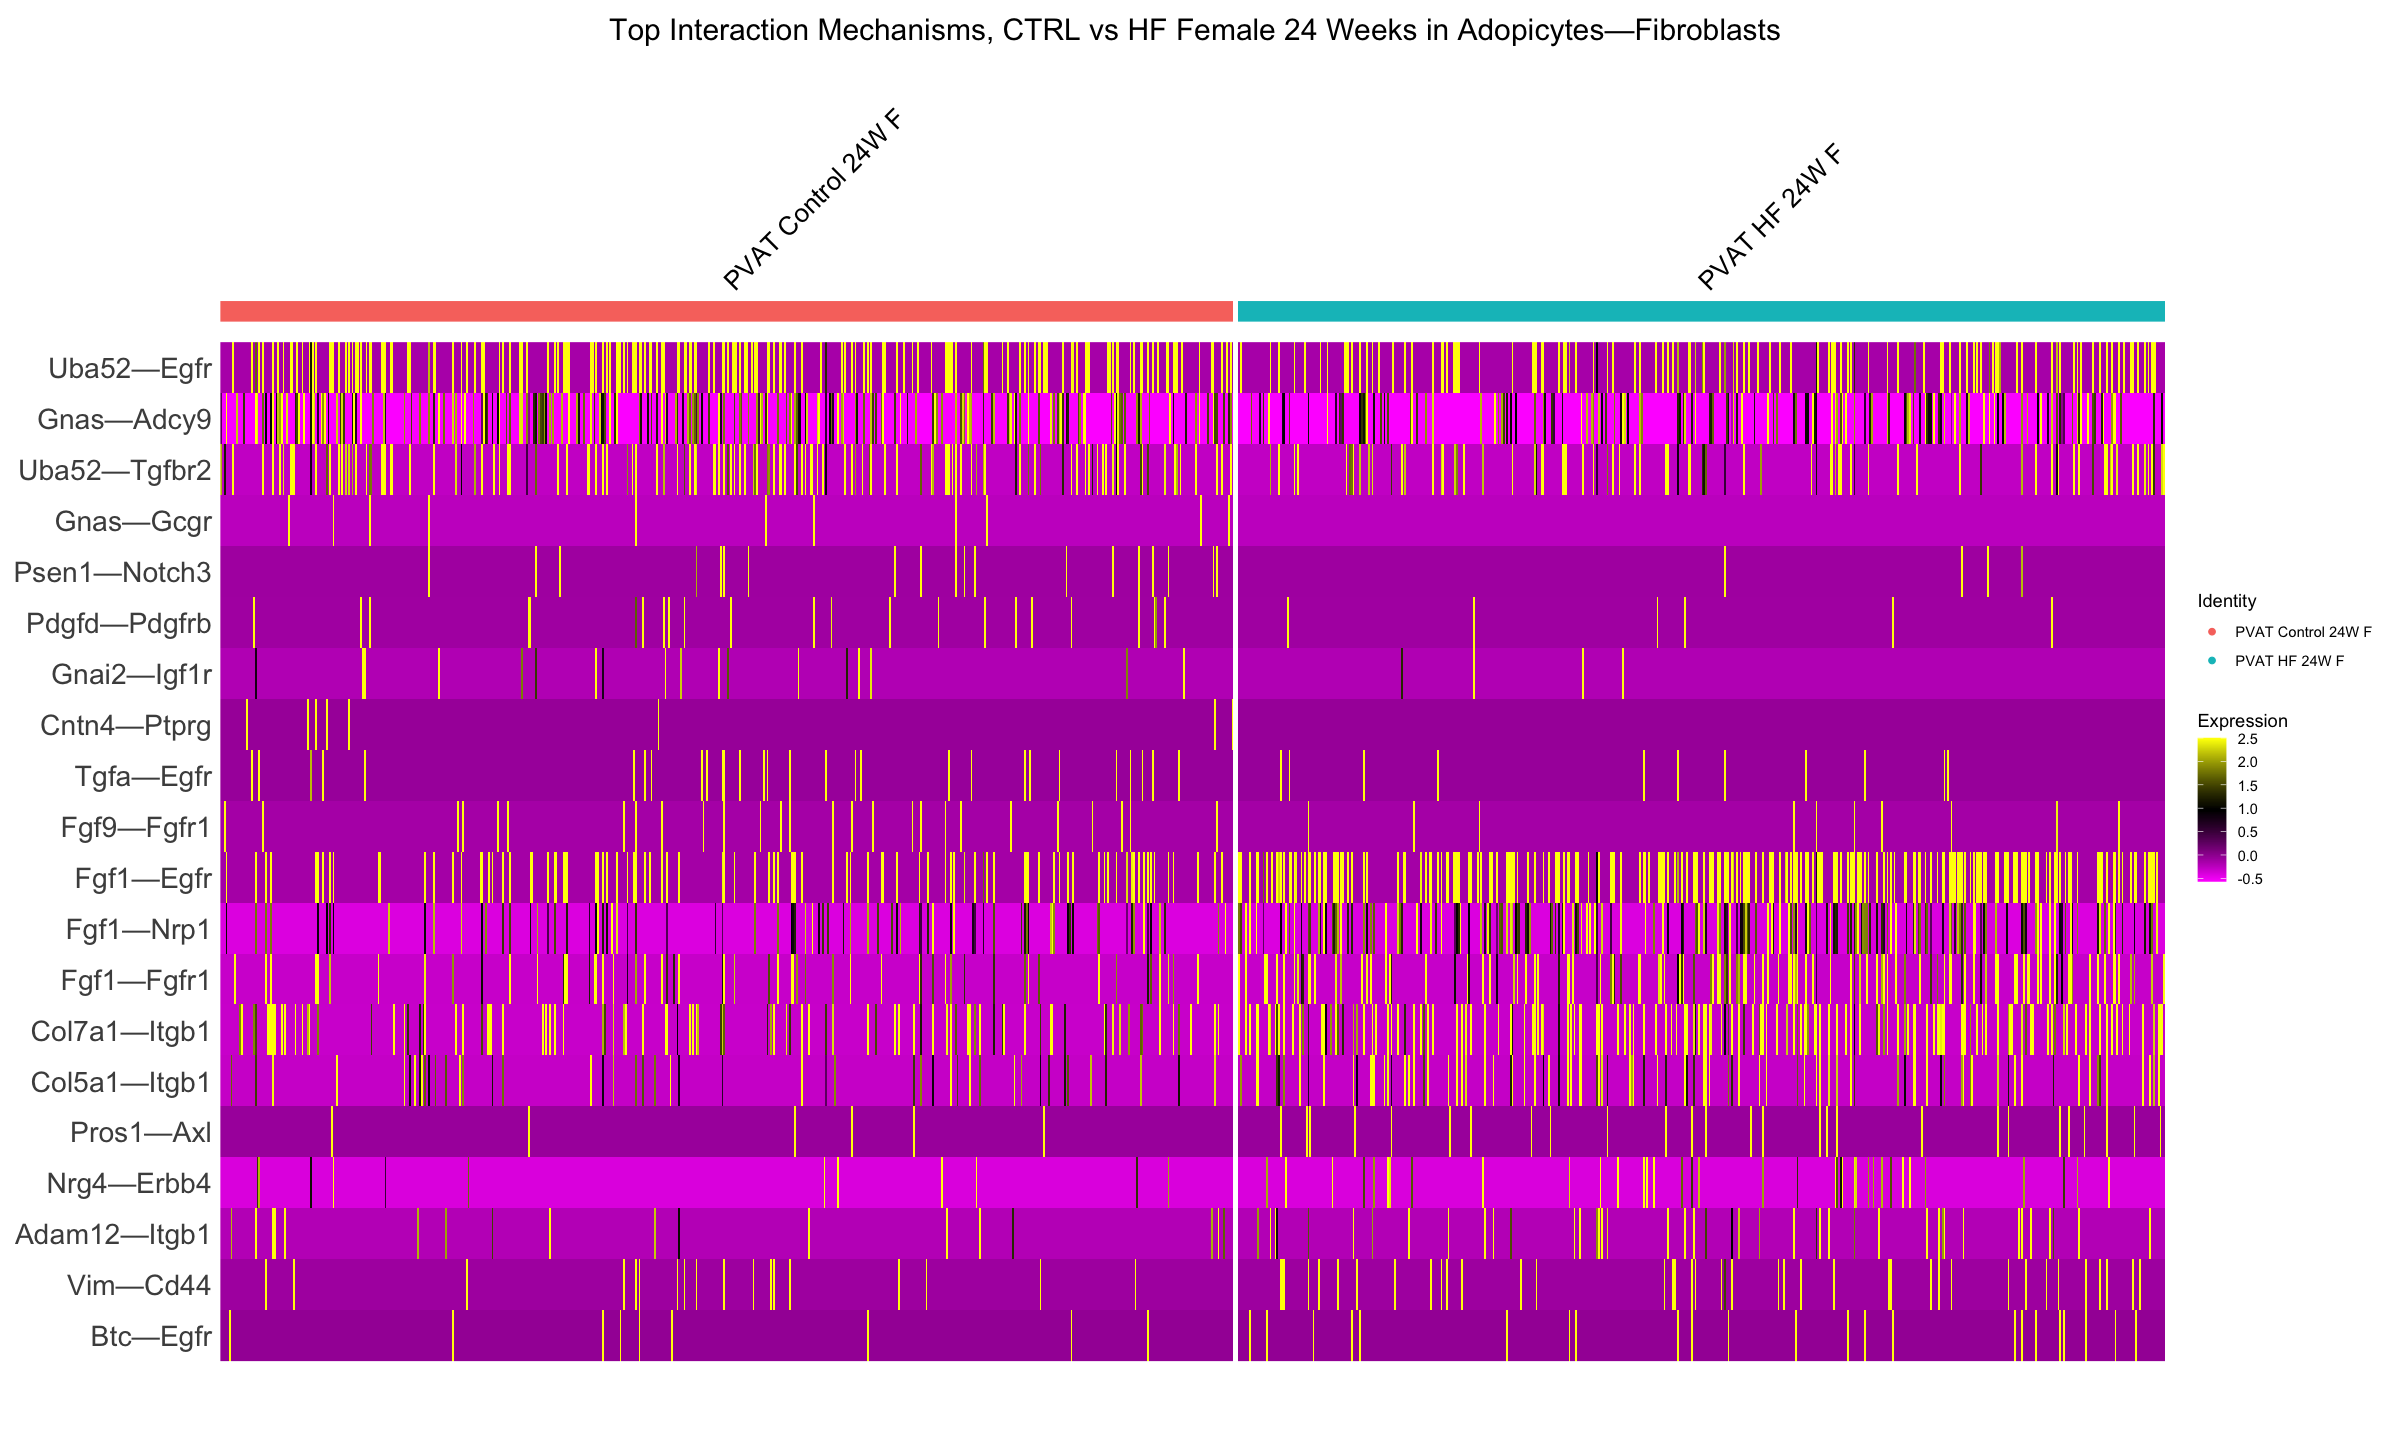

In [27]:
adipo_fibro <- celltocell_heatmap("Adipocytes—Fibroblasts")

options(repr.plot.width=20, repr.plot.height=12)
subs <- adipo_fibro[[1]]$subs
top10 <- adipo_fibro[[1]]$top10
Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_24W_F", "taPVAT_HF_24W_F"), 
                        labels = c("PVAT Control 24W F", "PVAT HF 24W F"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Female 24 Weeks in Adopicytes—Fibroblasts") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Female 24 Weeks in Adopicytes—Fibroblasts.pdf", plot = plot, width = 20, height = 12, dpi = 600)

[1] "Adipocytes—Endothelial_Cells:  taPVAT_Control_24W_F:1541"
[1] "Adipocytes—Endothelial_Cells:  taPVAT_HF_24W_F:1453"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_24W_F

Calculating cluster taPVAT_HF_24W_F



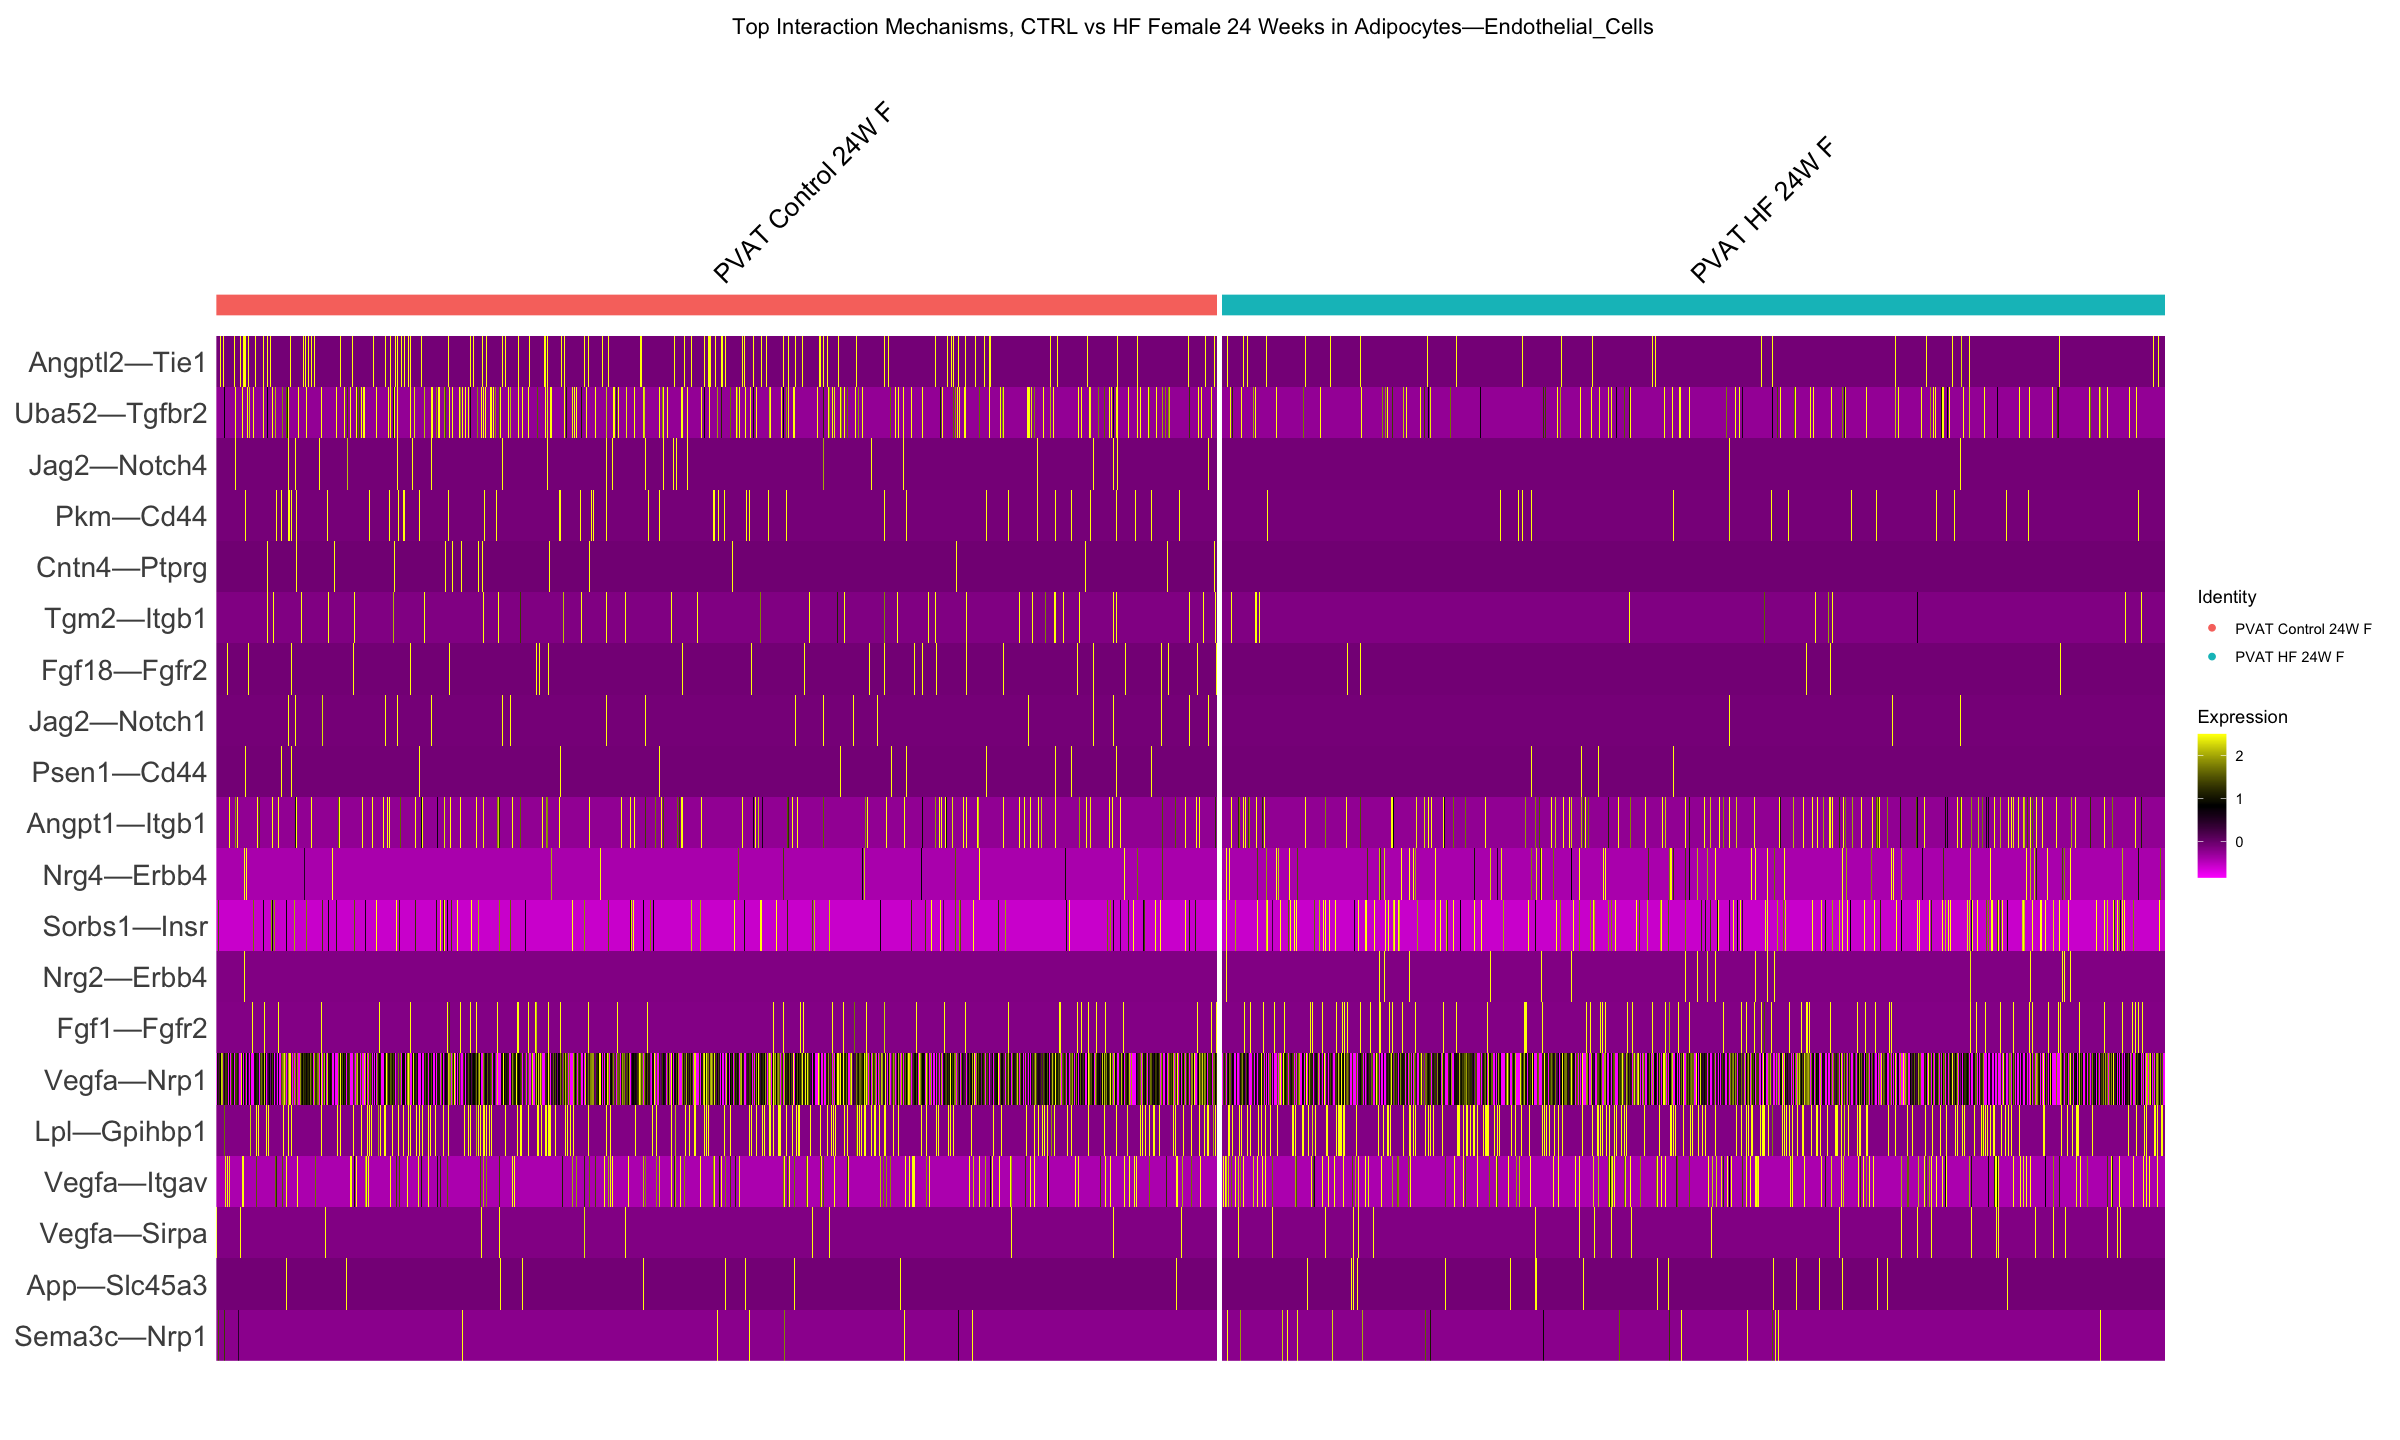

In [28]:
adipo_endo <- celltocell_heatmap("Adipocytes—Endothelial_Cells")

options(repr.plot.width=20, repr.plot.height=12)
subs <- adipo_endo[[1]]$subs
top10 <- adipo_endo[[1]]$top10
Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_24W_F", "taPVAT_HF_24W_F"), 
                        labels = c("PVAT Control 24W F", "PVAT HF 24W F"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Female 24 Weeks in Adipocytes—Endothelial_Cells") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Female 24 Weeks in Adipocytes—Endothelial_Cells.pdf", plot = plot, width = 20, height = 12, dpi = 600)

Centering and scaling data matrix

Finding variable features for layer data.1

Finding variable features for layer data.2

PC_ 1 
Positive:  Lama2—Itgb1, Lama4—Itgb1, Col3a1—Itgb1, Col5a2—Itgb1, Col4a1—Itgb1, Col5a1—Itgb1, Fbn1—Itgb1, Col6a1—Itgb1, Col6a3—Itgb1, Hspg2—Itgb1 
	   Angpt1—Itgb1, Adam12—Itgb1, Col4a4—Itgb1, Col1a2—Itgb1, Nid1—Itgb1, Col4a3—Itgb1, Col1a1—Itgb1, Adam9—Itgb1, Col4a5—Itgb1, Fn1—Itgb1 
	   Cxcl12—Itgb1, Fbln1—Itgb1, Adam17—Itgb1, Col18a1—Itgb1, Il15—Il15ra, Adam12—Sdc4, Dusp18—Itgb1, Col4a1—Itgav, Tgm2—Itgb1, Adam9—Itgav 
Negative:  Vegfa—Nrp1, Fgf13—Fgfr1, Fgf1—Nrp1, Nampt—Insr, Sema6a—Plxna2, Sema3c—Nrp1, Lpl—Vldlr, Rgmb—Bmpr2, Adipoq—Adipor2, Fgf7—Fgfr1 
	   Sema3c—Plxnd1, Rgmb—Neo1, C4b—Cd46, Calr—Scarf1, Clcf1—Lifr, Fgf18—Fgfr1, Fn1—Il17rc, Uba52—Tgfbr1, Vegfa—Nrp2, Ecm1—Cachd1 
	   Fgf12—Fgfr2, Vegfa—Itgav, Bmp4—Acvr2a, Bmp4—Acvr1, Col1a1—Itga1, Lama2—Itga7, Wnt5a—Fzd4, Igfbp4—Lrp6, Egf—Erbb4, Psen1—Ncstn 
PC_ 2 
Positive:  Gnas—Adora1, Col6a1—Itgb1, Gnas

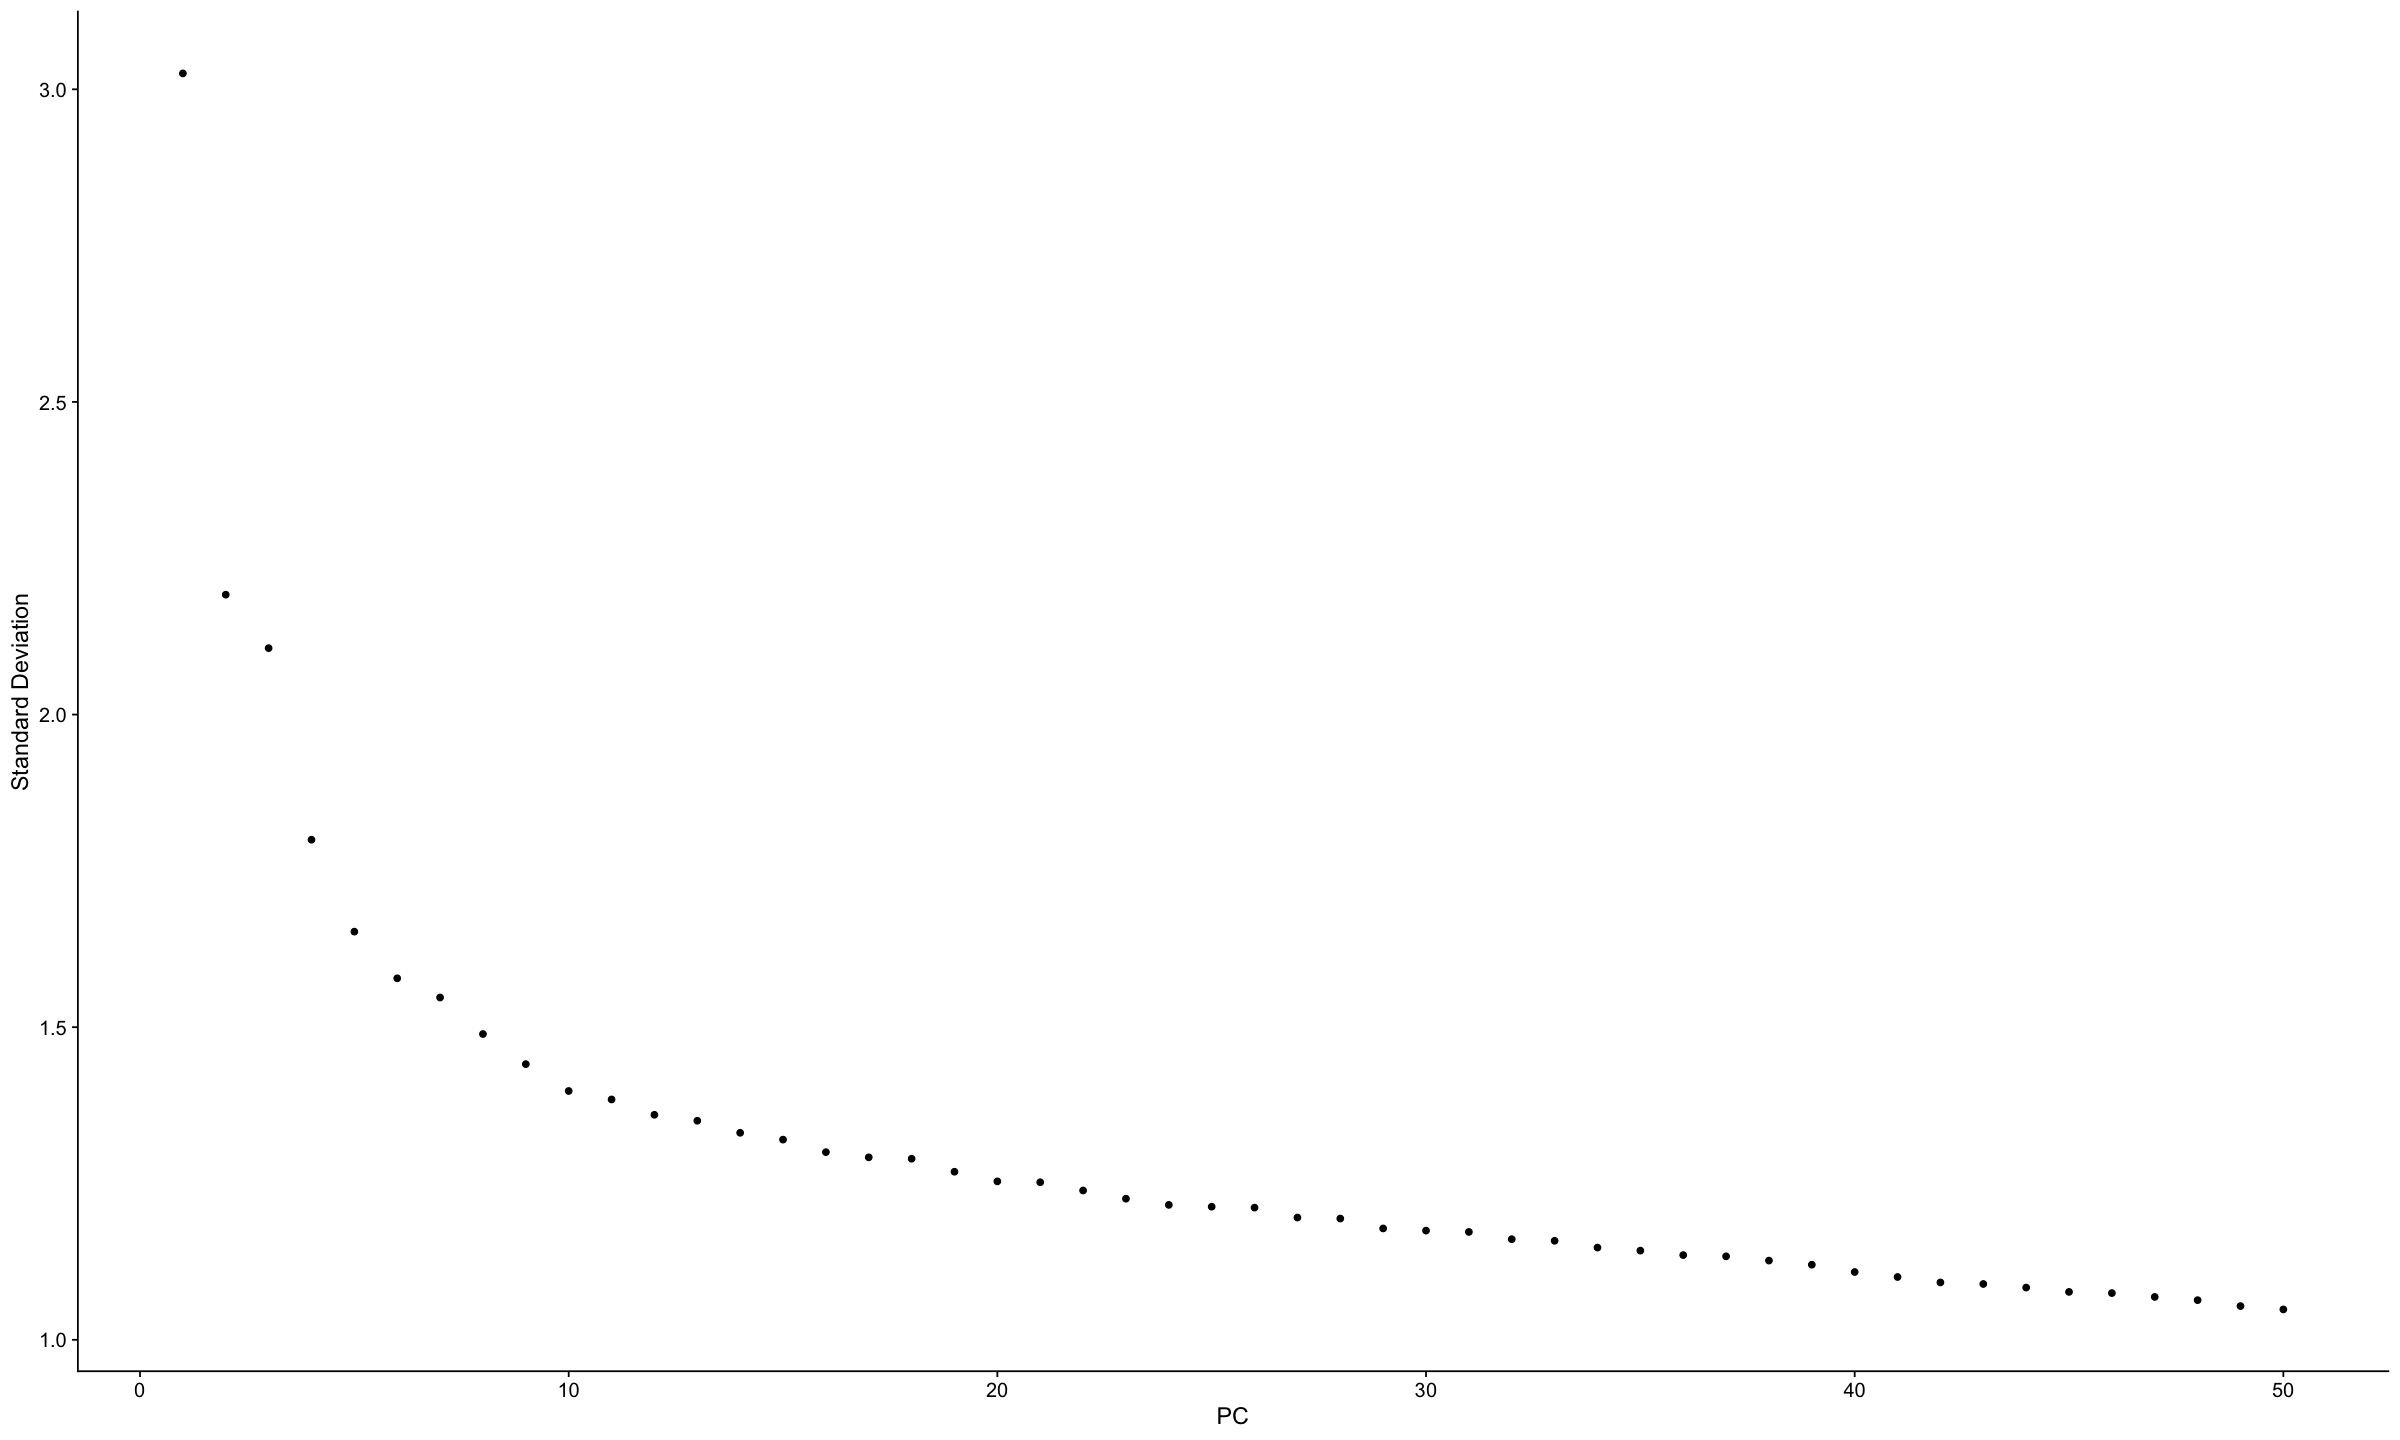

In [34]:
# Perform visualization for VectorTypes of interest
#VOI <- c("CD14 Mono—DC")
VOI <- "Fibroblasts—Adipocytes"

Idents(scc.sub) <- scc.sub@meta.data$VectorType
voi.data <- subset(scc.sub,idents = VOI)
voi.data <- ScaleData(voi.data)
voi.data <- FindVariableFeatures(voi.data,selection.method = "disp")
voi.data <- RunPCA(voi.data,npcs = 50)
ElbowPlot(voi.data,ndim=50)

15:13:22 UMAP embedding parameters a = 0.9922 b = 1.112

15:13:22 Read 1264 rows and found 10 numeric columns

15:13:22 Using Annoy for neighbor search, n_neighbors = 30

15:13:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:13:22 Writing NN index file to temp file /var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T//RtmpMWjMdo/file10fcf1c4628fc

15:13:22 Searching Annoy index using 1 thread, search_k = 3000

15:13:23 Annoy recall = 100%

15:13:23 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:13:24 Initializing from normalized Laplacian + noise (using RSpectra)

15:13:24 Commencing optimization for 500 epochs, with 49256 positive edges

15:13:26 Optimization finished



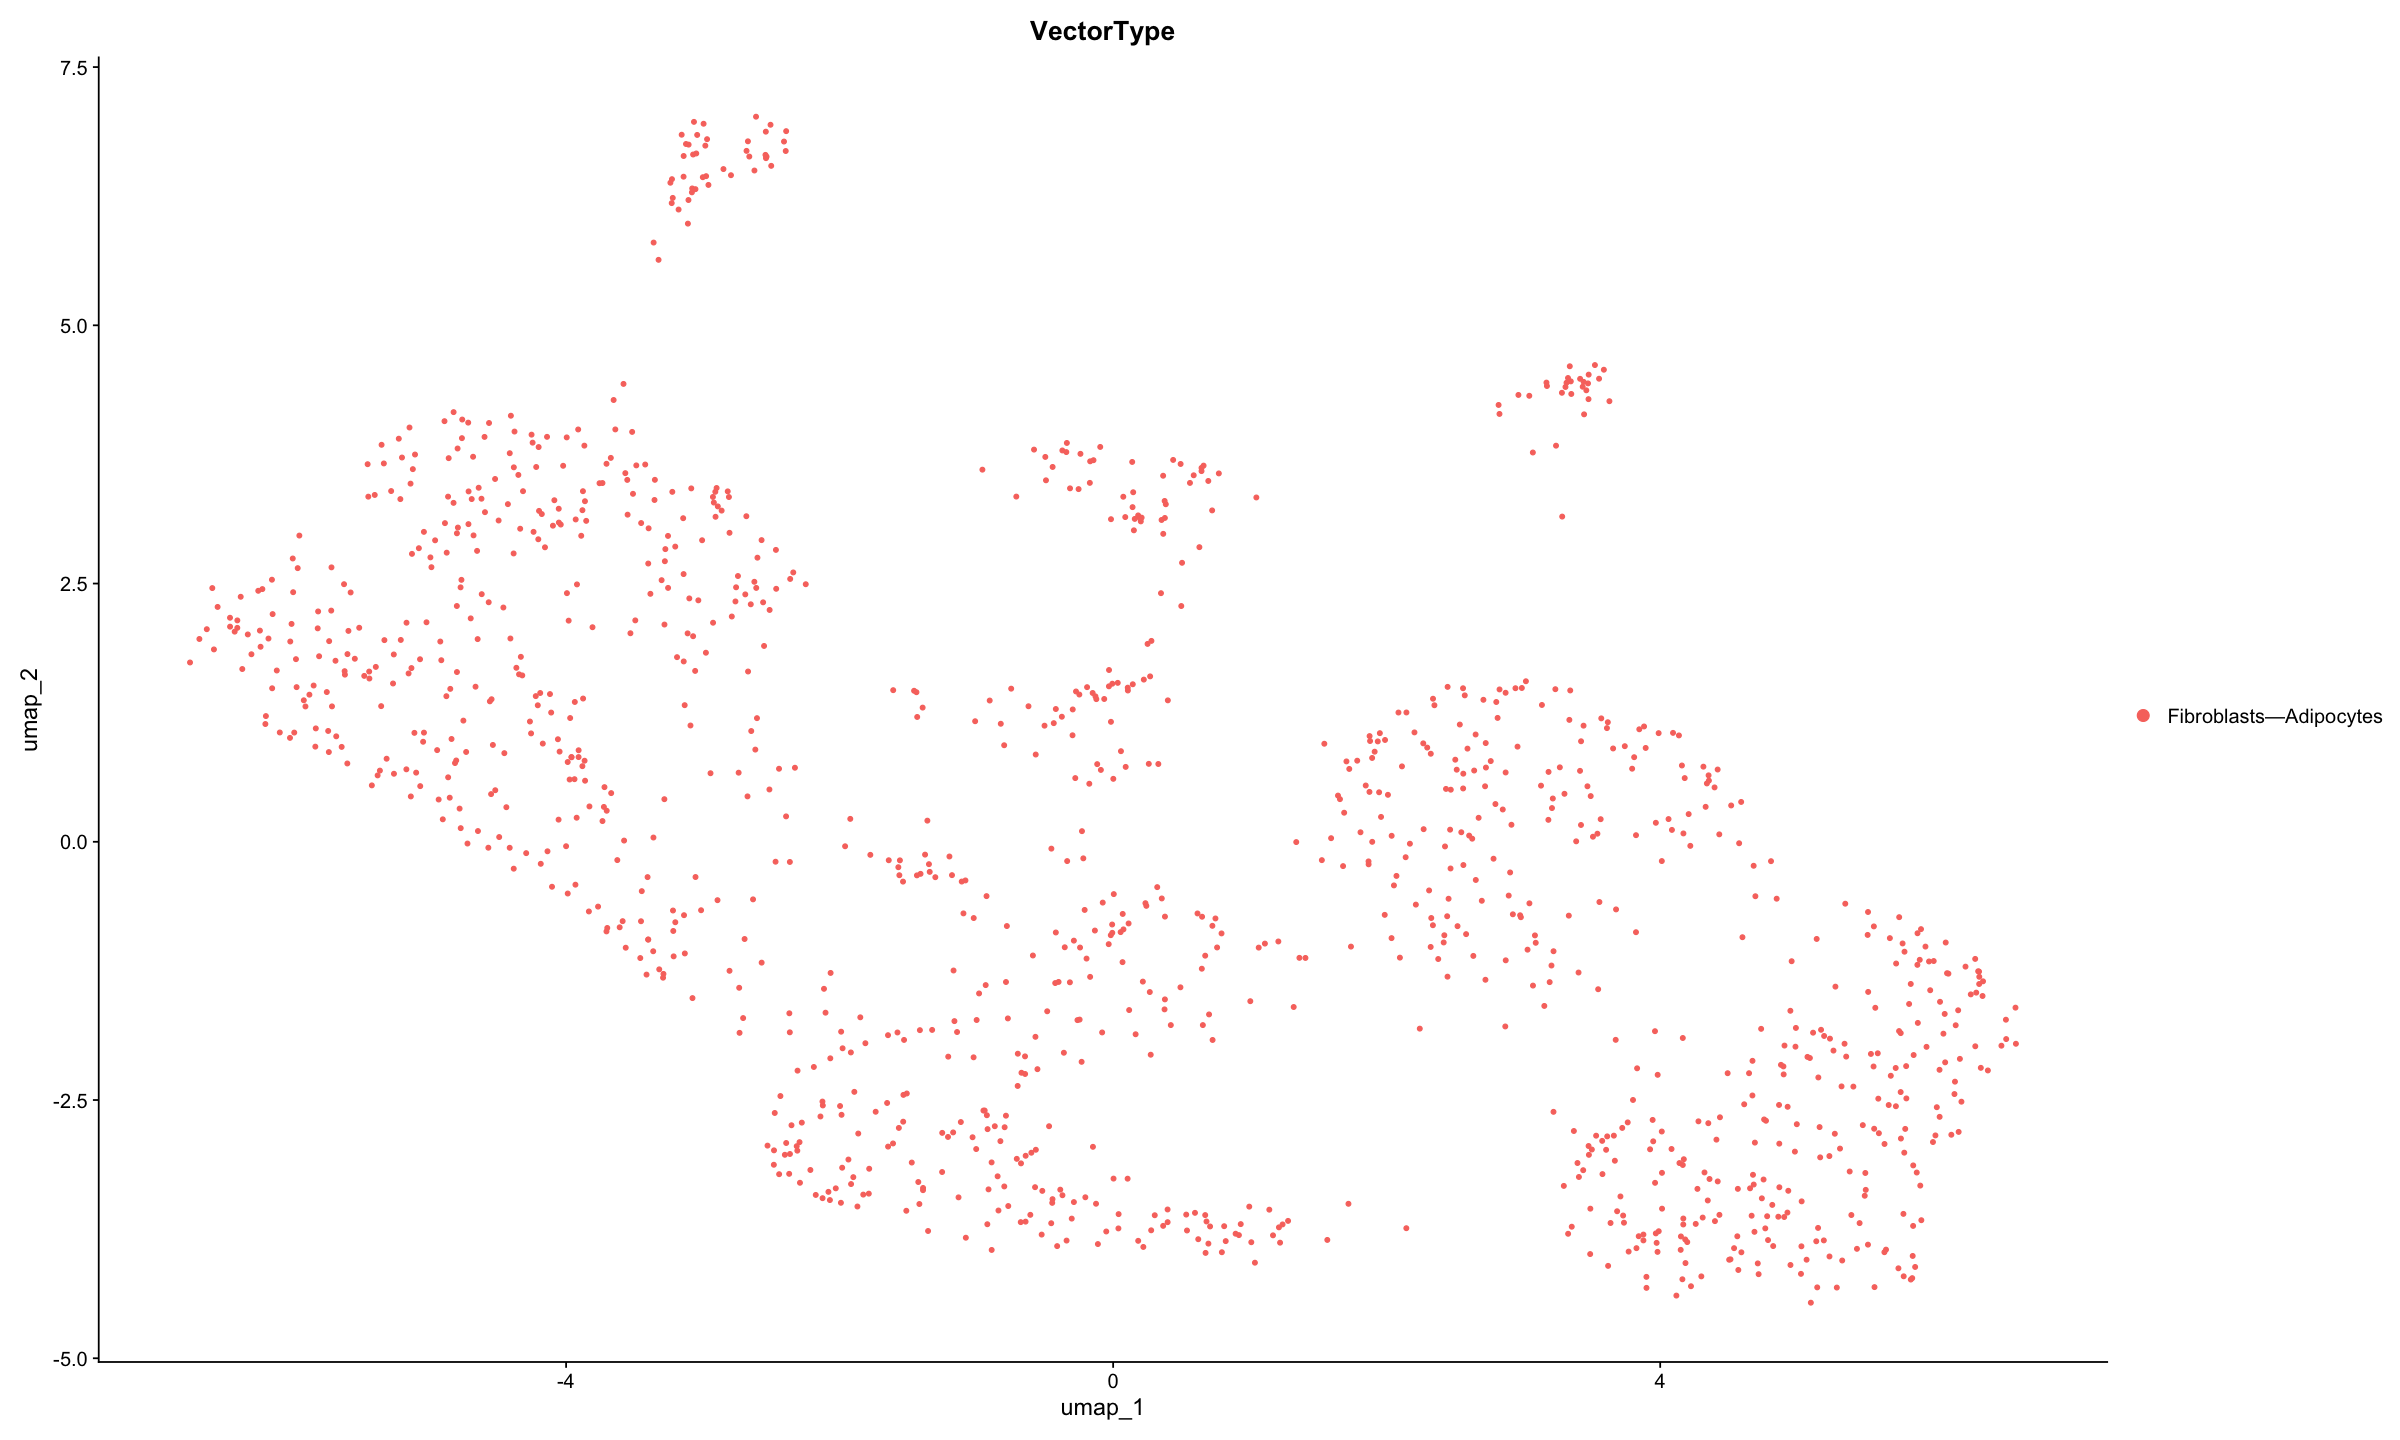

In [35]:
voi.data <- RunUMAP(voi.data,dims = 1:10)
DimPlot(voi.data,group.by = 'VectorType')

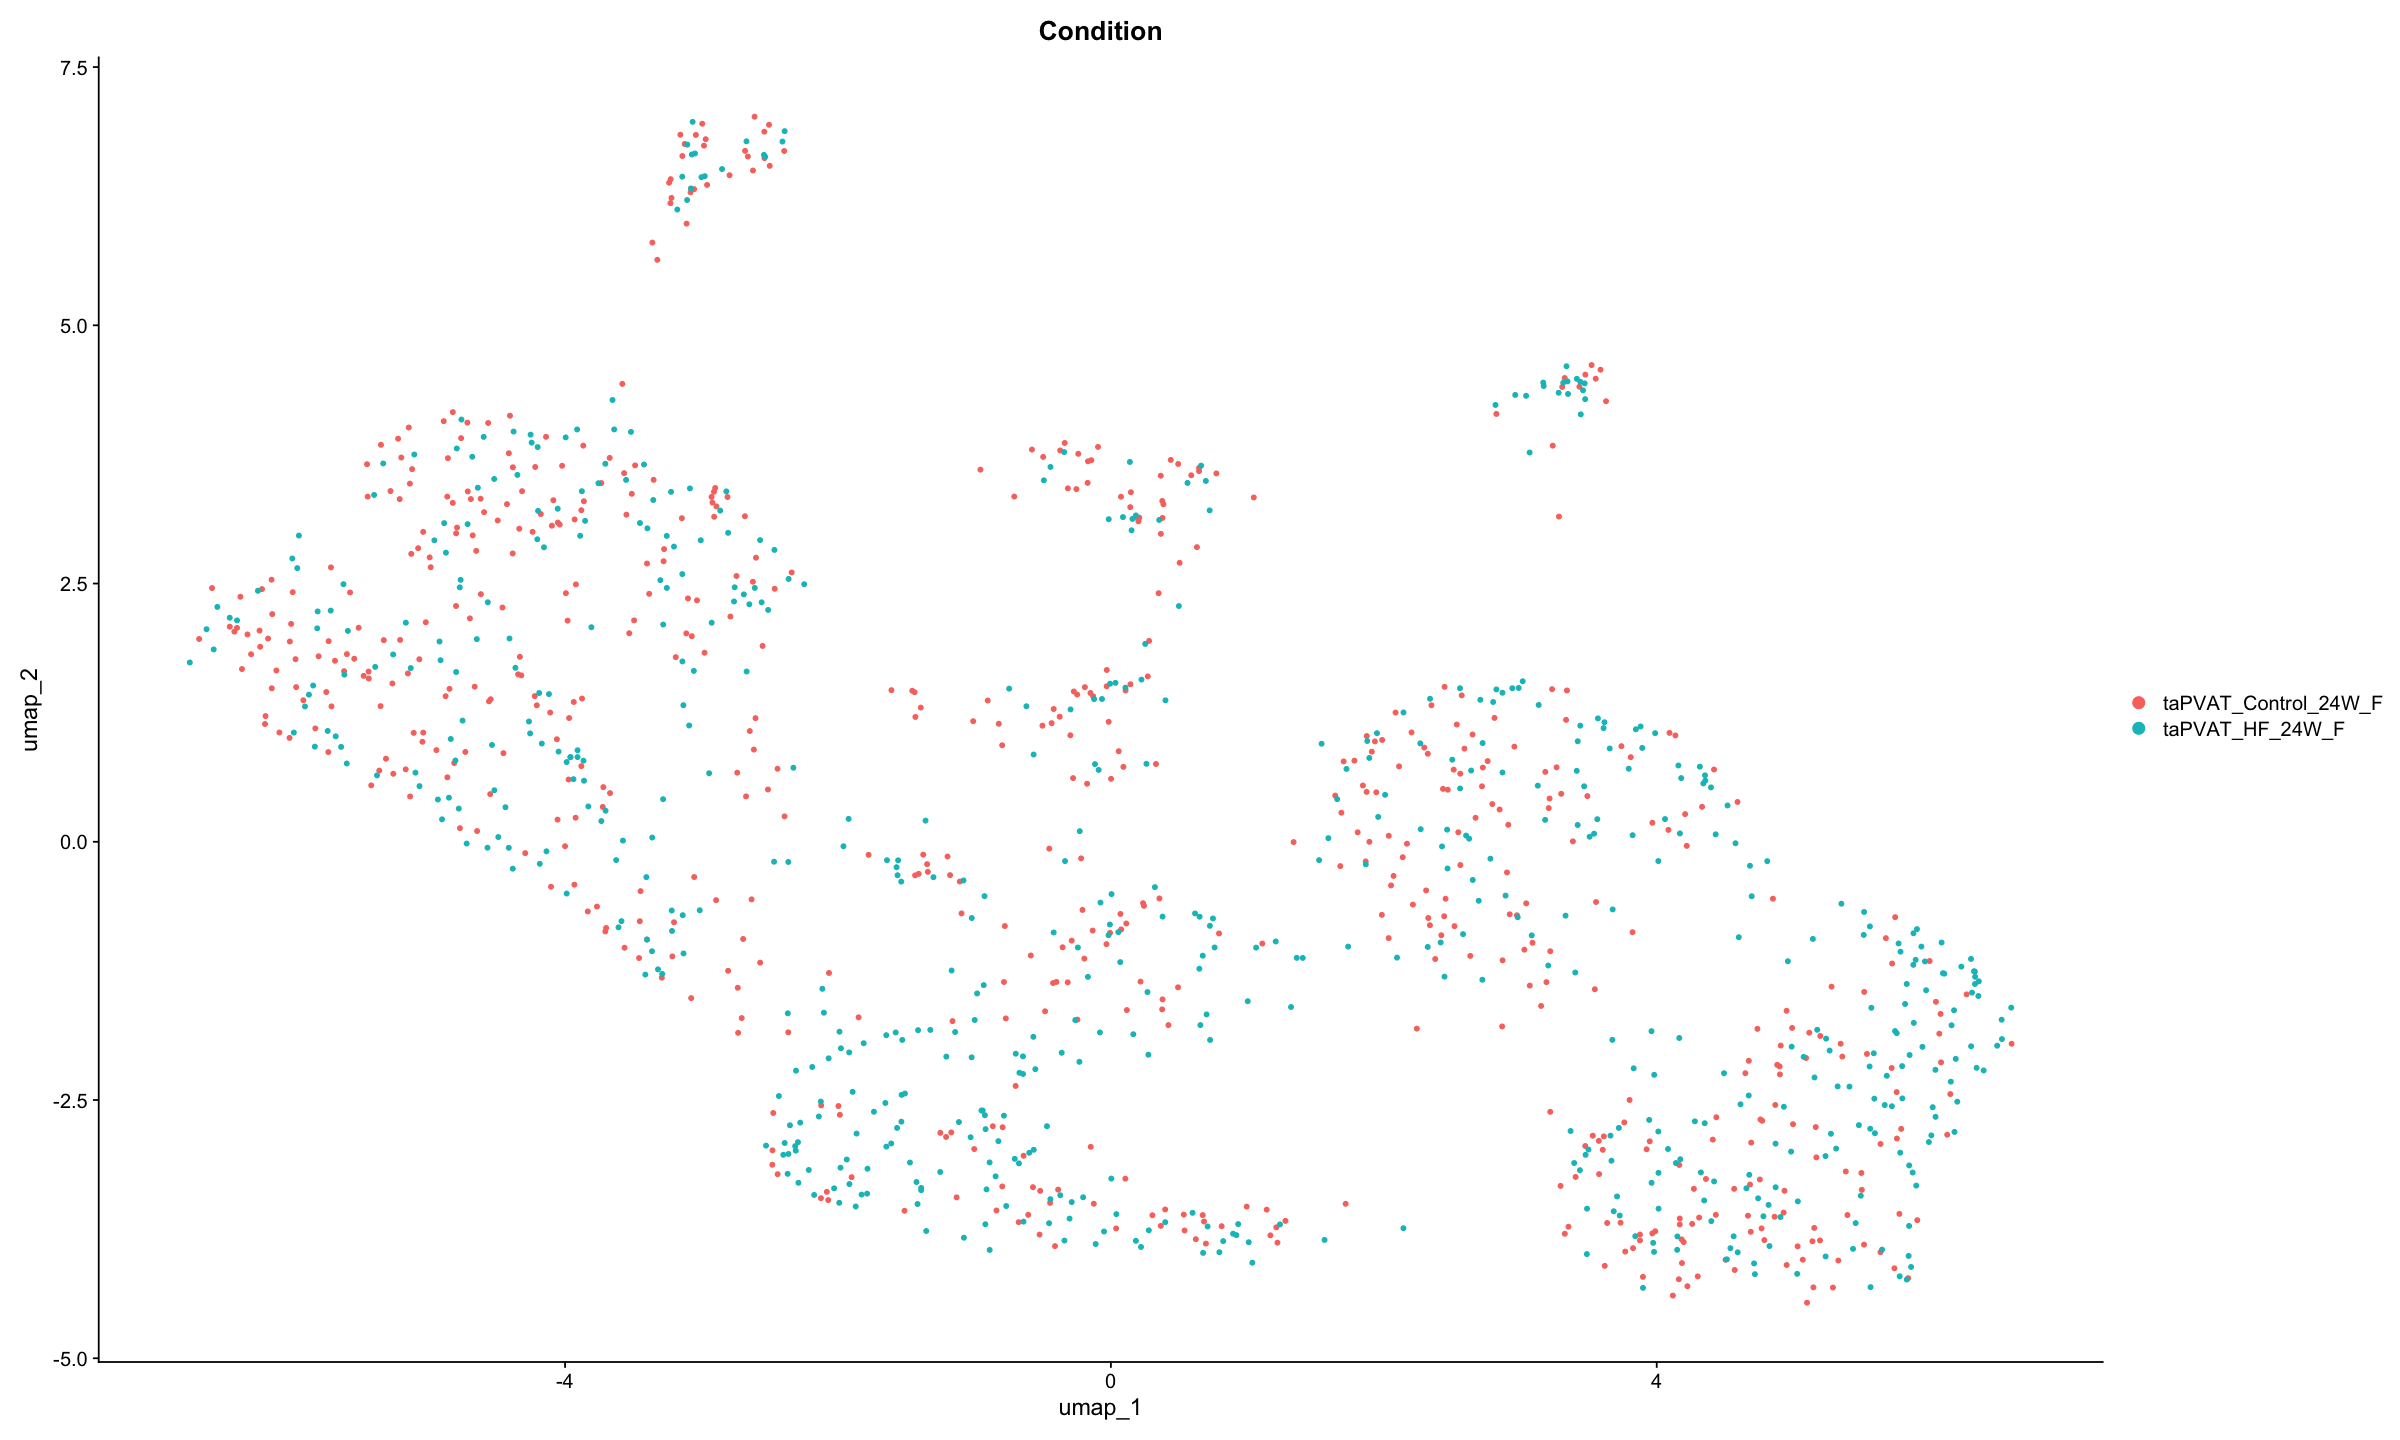

In [36]:
DimPlot(voi.data,group.by = 'Condition')

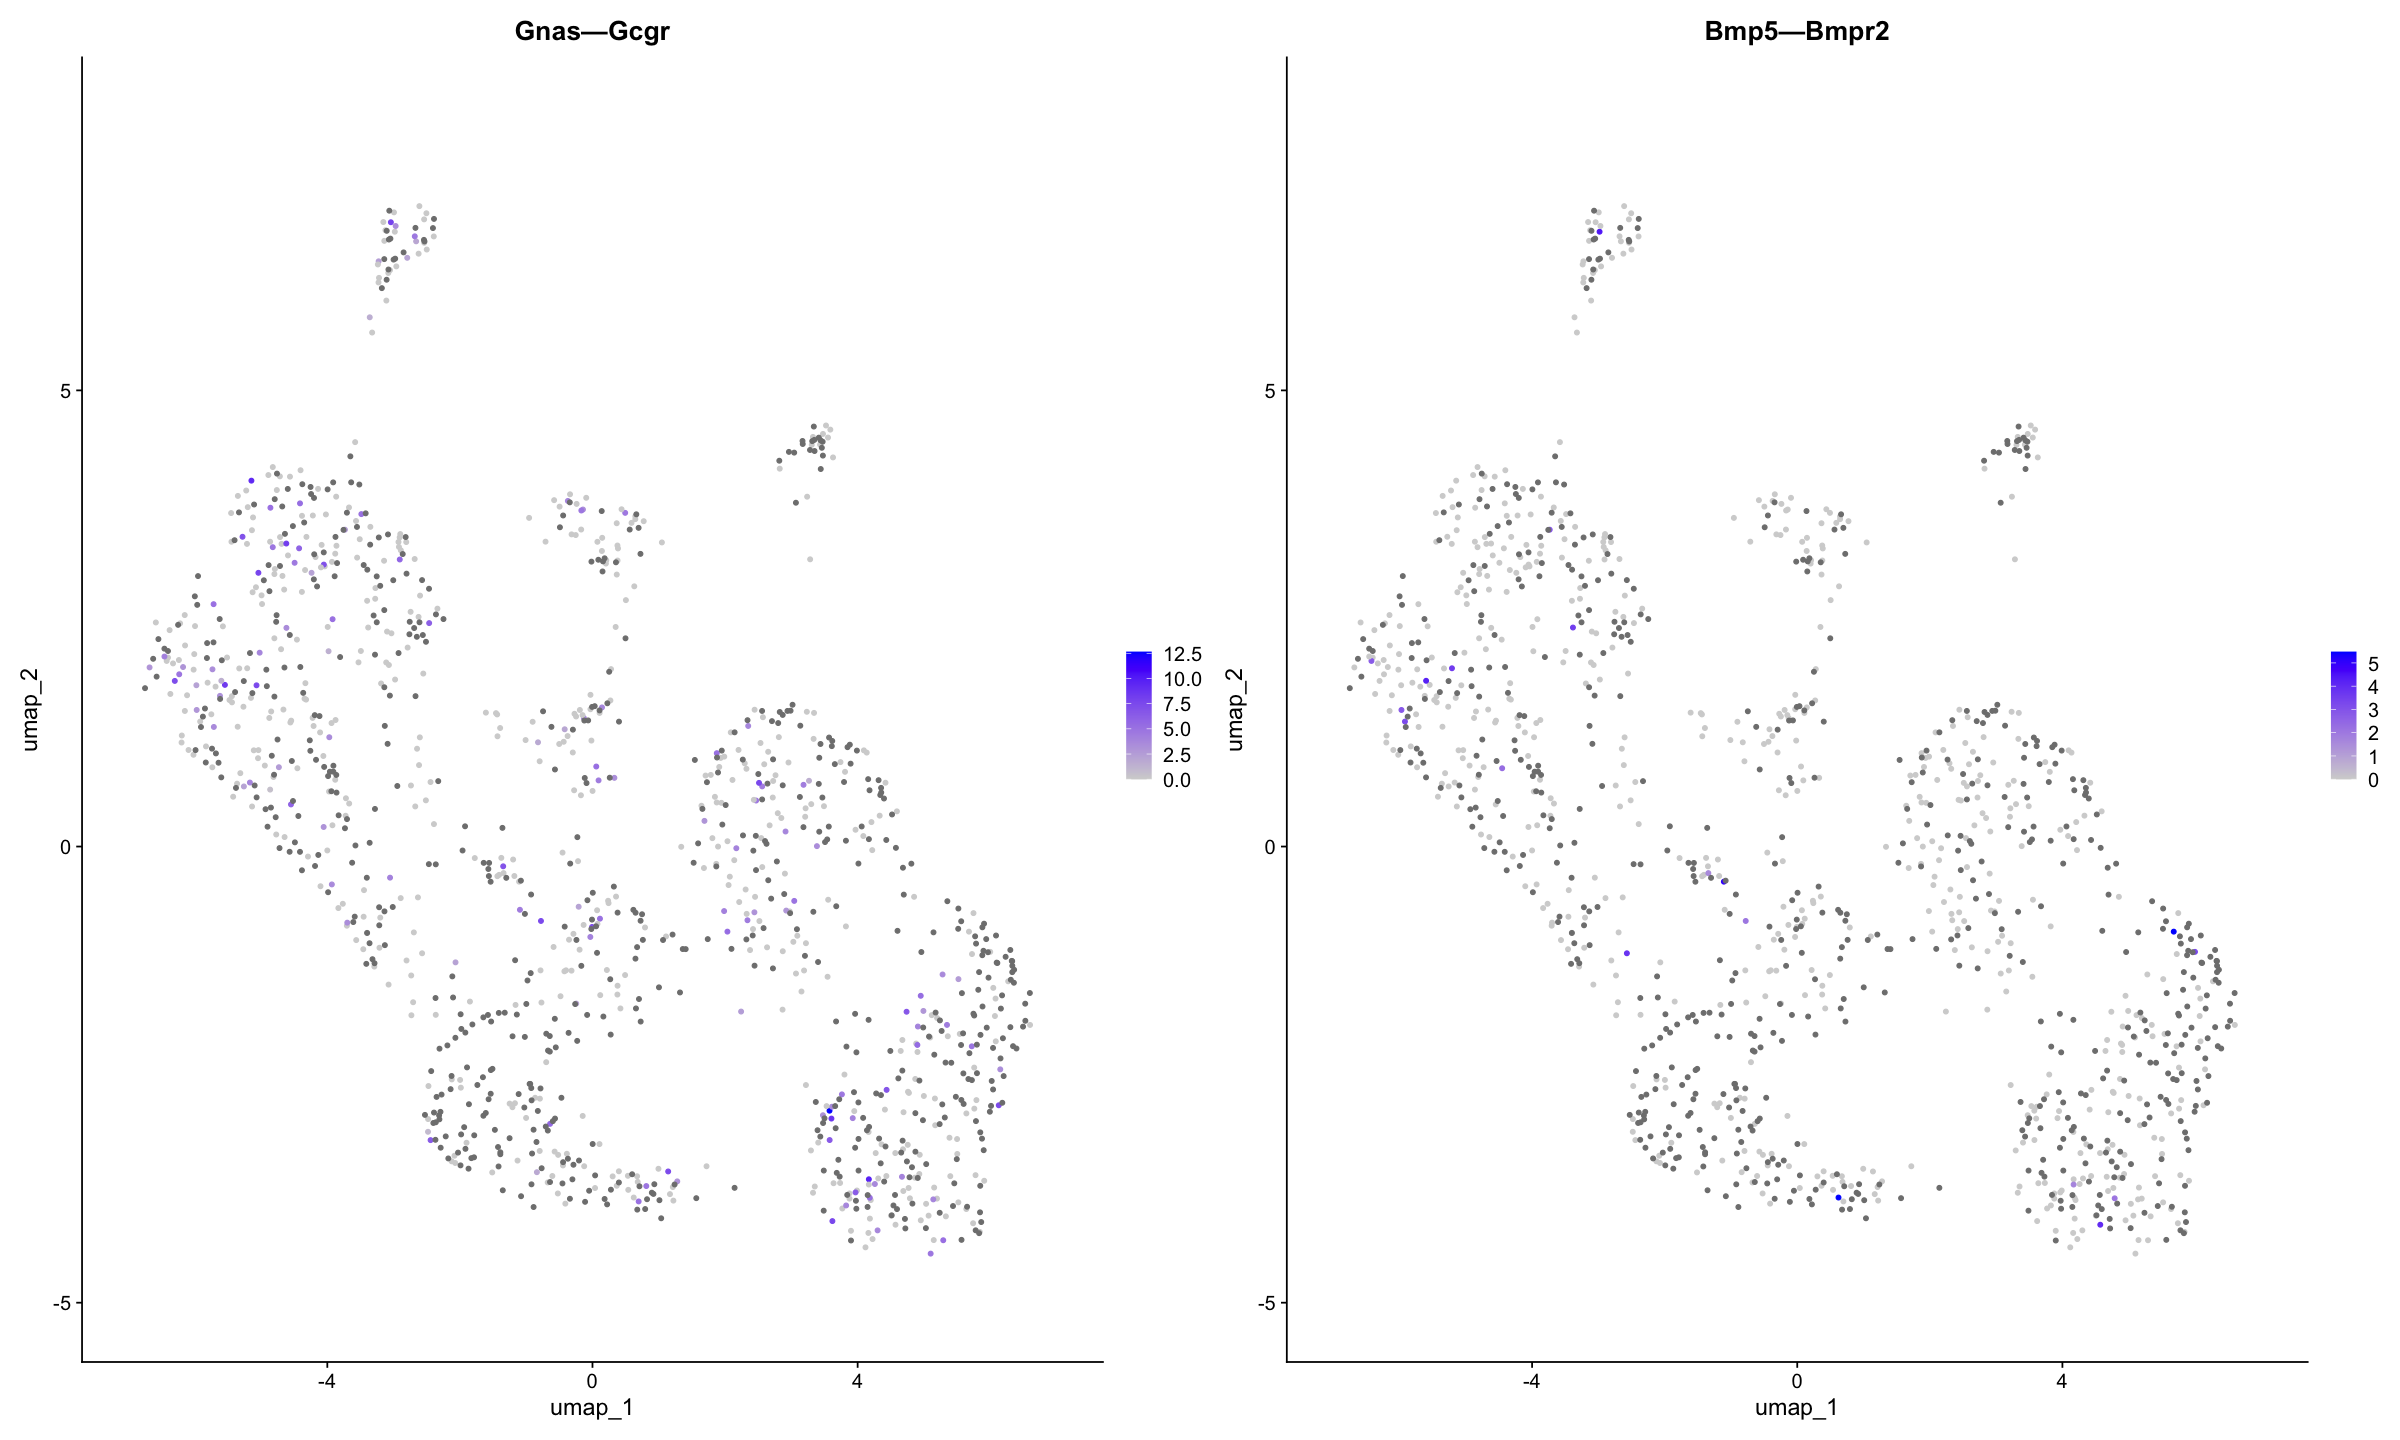

In [37]:
FeaturePlot(voi.data,
            features = c('Gnas—Gcgr','Bmp5—Bmpr2', 'Col11a1—Itgb1'),max.cutoff = 150)

In [38]:
voi.data <- JoinLayers(object = voi.data, assay = "CellToCell", layers = c("data", "scale.data"))

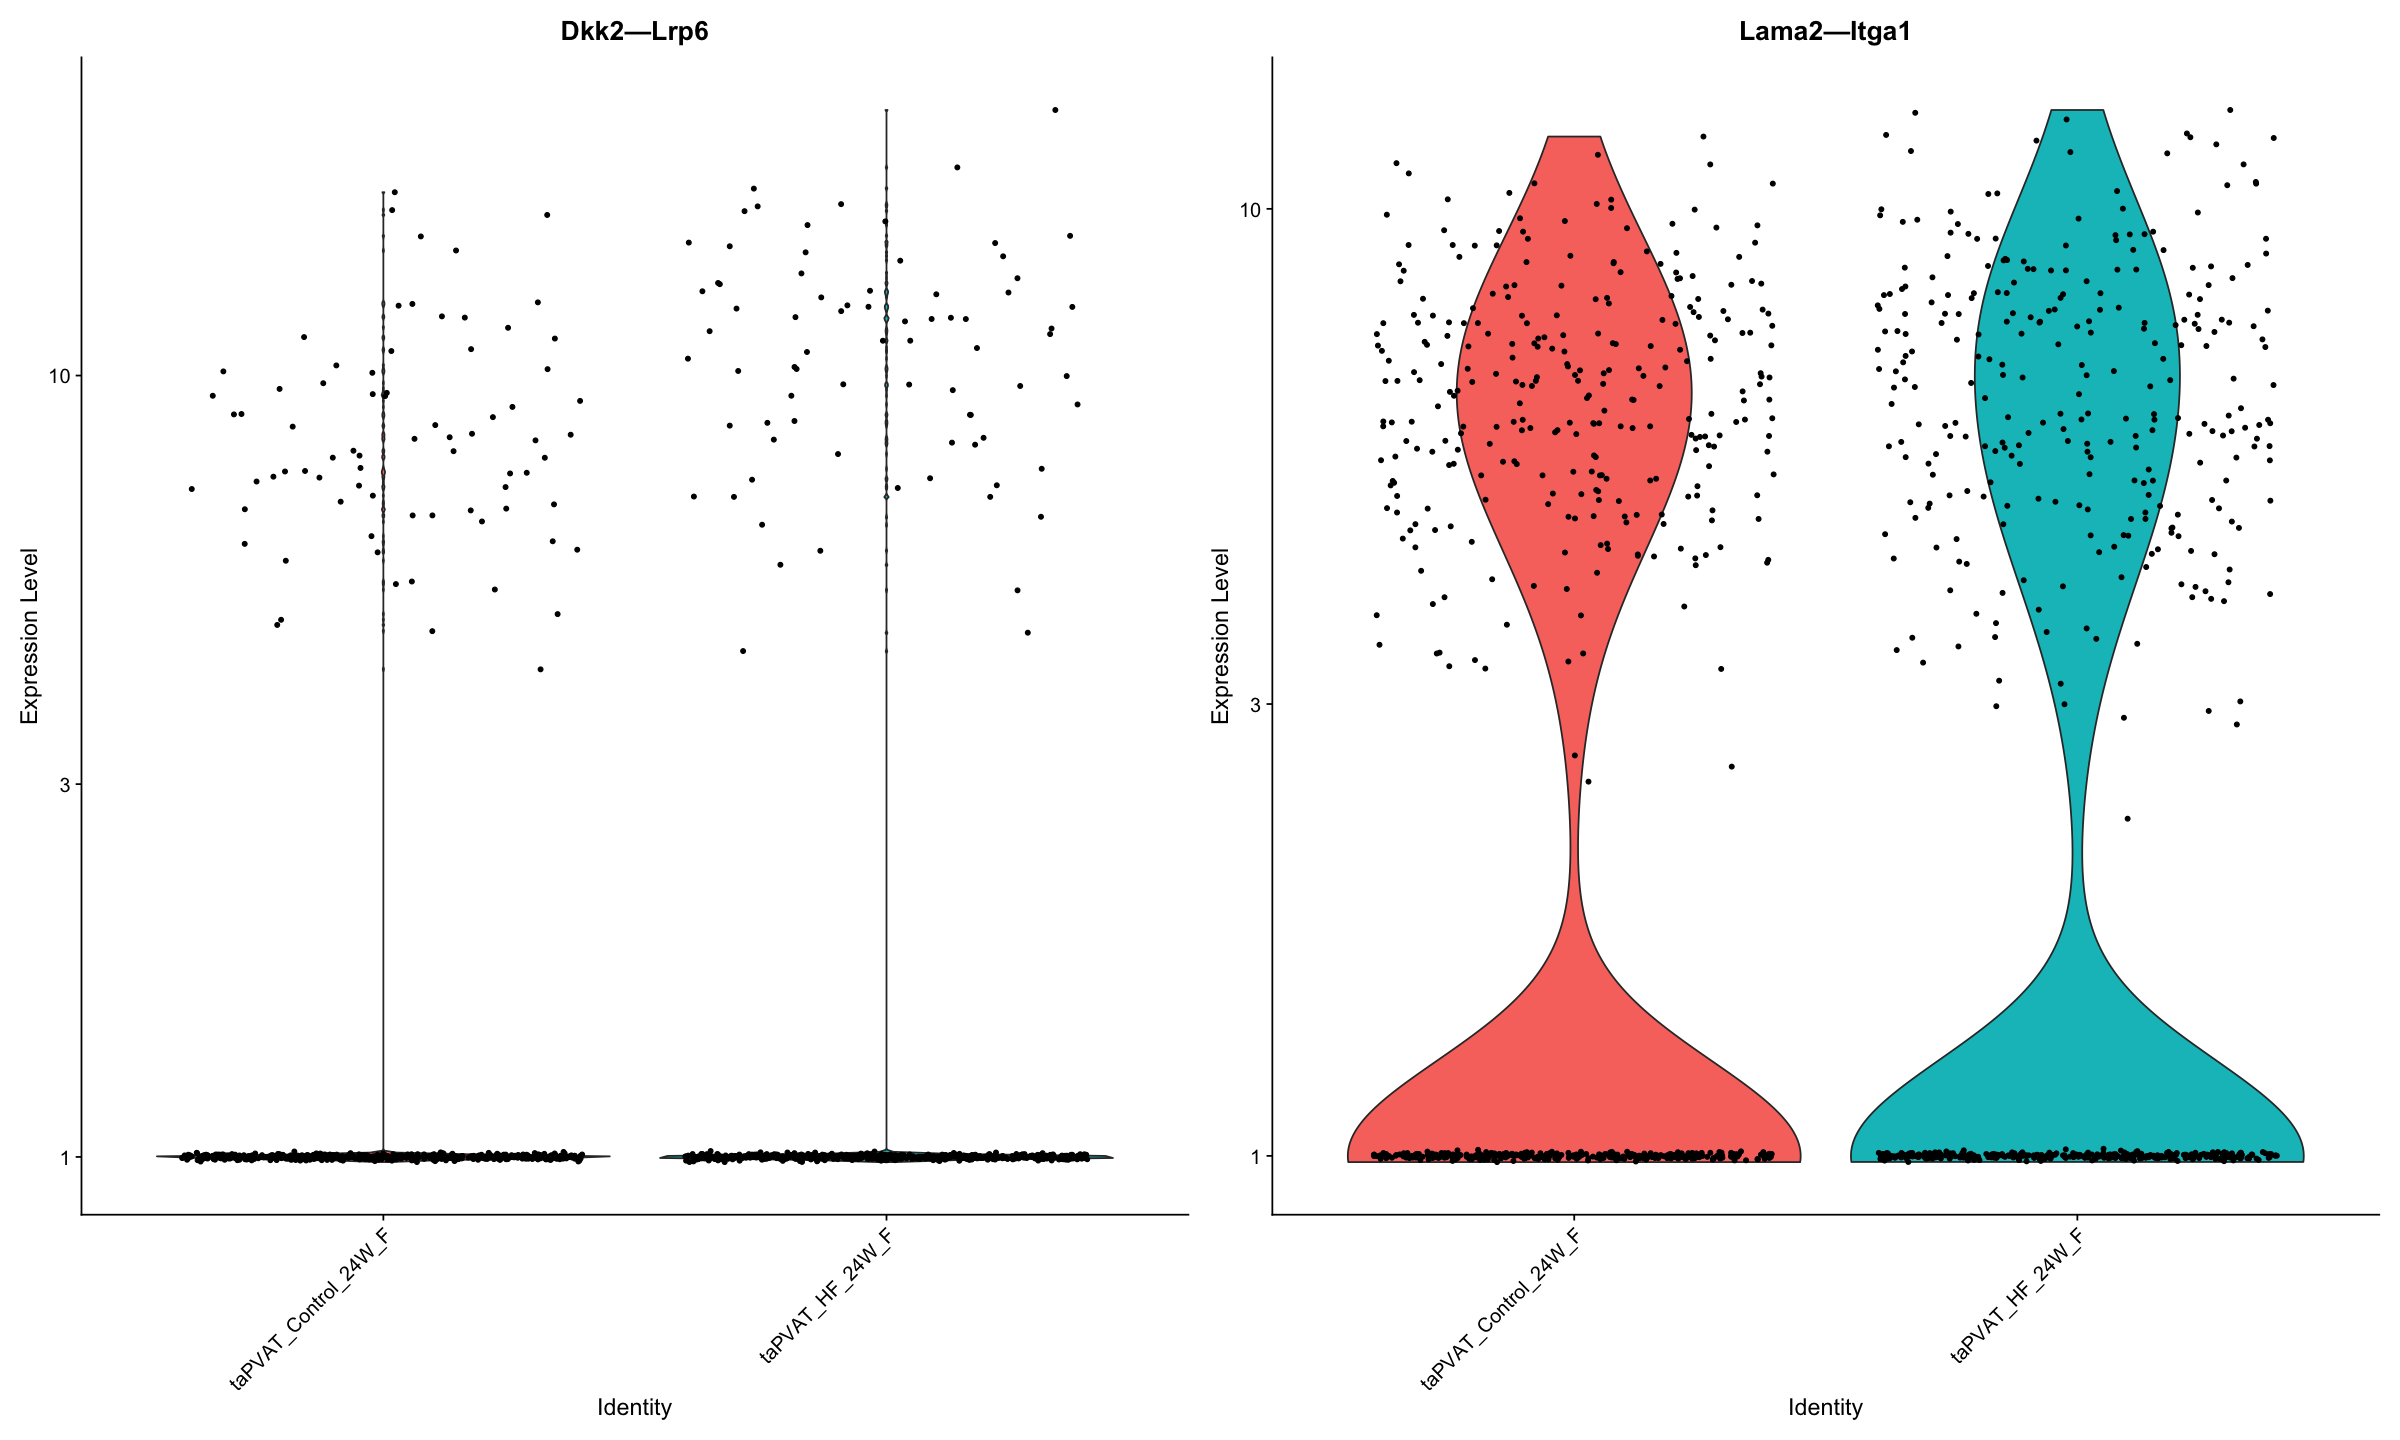

In [39]:
VlnPlot(voi.data,
            features = c('Dkk2—Lrp6','Lama2—Itga1'),log = T,group.by = 'Condition')

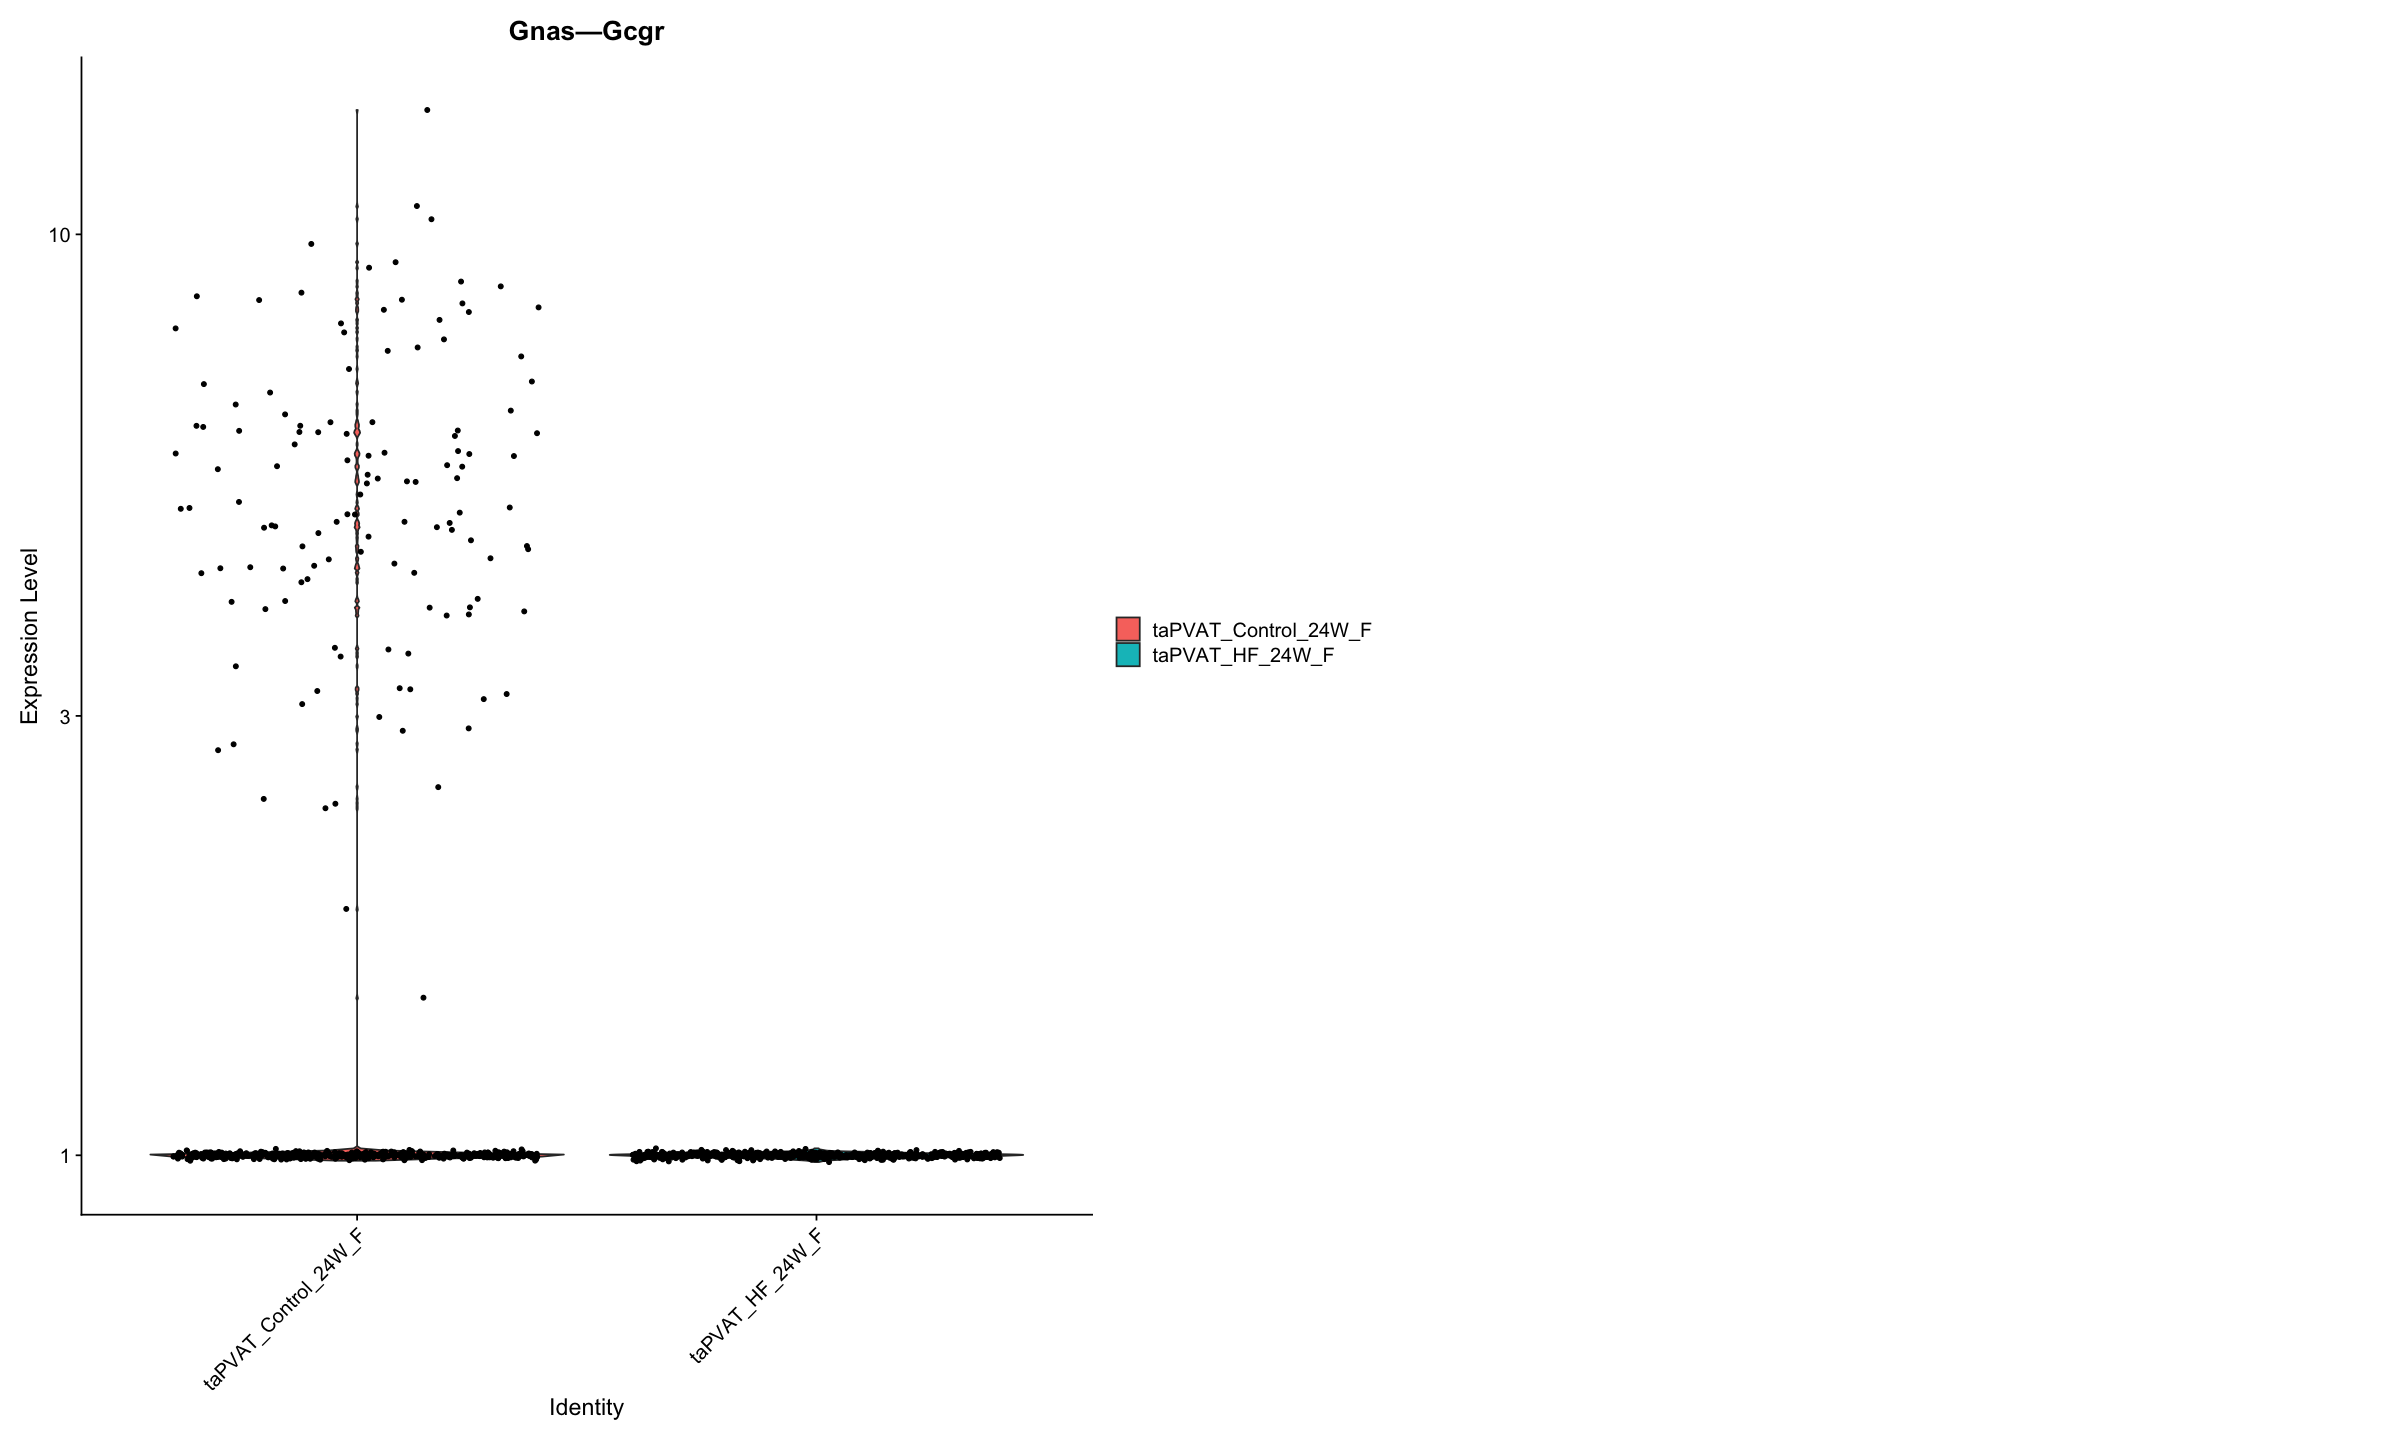

In [40]:
VlnPlot(voi.data,
            features = c('Gnas—Gcgr','Plau—Lrp1'),log = T,group.by = 'Condition')

In [41]:
top10

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster             
1  9.806587e-16  4.361451  0.093 0.024 7.050936e-13 taPVAT_Control_24W_F
2  2.270661e-09  2.739868  0.169 0.096 1.632606e-06 taPVAT_Control_24W_F
3  1.437135e-06  5.503661  0.023 0.003 1.033300e-03 taPVAT_Control_24W_F
4  1.619223e-06  5.749101  0.049 0.018 1.164222e-03 taPVAT_Control_24W_F
5  2.955220e-06 16.554186  0.015 0.000 2.124803e-03 taPVAT_Control_24W_F
6  8.083814e-06  2.795742  0.040 0.014 5.812262e-03 taPVAT_Control_24W_F
7  4.943672e-05  4.571400  0.021 0.004 3.554500e-02 taPVAT_Control_24W_F
8  6.946175e-04  3.362867  0.017 0.004 4.994300e-01 taPVAT_Control_24W_F
9  2.399039e-03  3.064966  0.016 0.005 1.000000e+00 taPVAT_Control_24W_F
10 6.391824e-03  3.495951  0.094 0.126 1.000000e+00 taPVAT_Control_24W_F
11 7.455807e-12  4.581666  0.063 0.015 5.360725e-09 taPVAT_HF_24W_F     
12 1.623576e-07  6.258467  0.126 0.073 1.167351e-04 taPVAT_HF_24W_F     
13 3.233267e-06  6.755230  0.016 0.001 2.324719e-03 taPVAT_HF_24W_F     
14 3.872862e-04  2.813705  0.075 0.045 2.784588e-01 taPVAT_HF_24W_F     
15 9.482831e-04  3.778371  0.733 0.784 6.818156e-01 taPVAT_HF_24W_F     
16 1.266711e-03  6.143250  0.193 0.162 9.107654e-01 taPVAT_HF_24W_F     
17 1.314933e-03  2.838633  0.164 0.126 9.454370e-01 taPVAT_HF_24W_F     
18 2.026036e-03  4.209821  0.026 0.011 1.000000e+00 taPVAT_HF_24W_F     
19 2.773058e-03  3.028244  0.019 0.006 1.000000e+00 taPVAT_HF_24W_F     
20 8.139154e-03  3.919930  0.025 0.012 1.000000e+00 taPVAT_HF_24W_F     
   gene        
1  Angptl2—Tie1
2  Uba52—Tgfbr2
3  Jag2—Notch4 
4  Pkm—Cd44    
5  Cntn4—Ptprg 
6  Tgm2—Itgb1  
7  Fgf18—Fgfr2 
8  Jag2—Notch1 
9  Psen1—Cd44  
10 Angpt1—Itgb1
11 Nrg4—Erbb4  
12 Sorbs1—Insr 
13 Nrg2—Erbb4  
14 Fgf1—Fgfr2  
15 Vegfa—Nrp1  
16 Lpl—Gpihbp1 
17 Vegfa—Itgav 
18 Vegfa—Sirpa 
19 App—Slc45a3 
20 Sema3c—Nrp1

In [42]:
voi.data@assays

$CellToCell
Assay (v5) data with 719 features for 1264 cells
Top 10 variable features:
 Dkk2—Lrp6, Ntf3—Ntrk3, Rspo3—Lrp6, Vegfa—Nrp1, Fbn1—Itgb1,
Col4a1—Itga1, Sema3c—Nrp1, Lamc1—Itga1, Igfbp4—Lrp6, Gnas—Adcy9 
Layers:
 data, counts.1, counts.2, scale.data 


In [92]:
'Plau—Itgav'  %in%  rownames(voi.data@assays$CellToCell)

[1] TRUE

In [93]:
length(rownames(voi.data@assays$CellToCell))

[1] 853

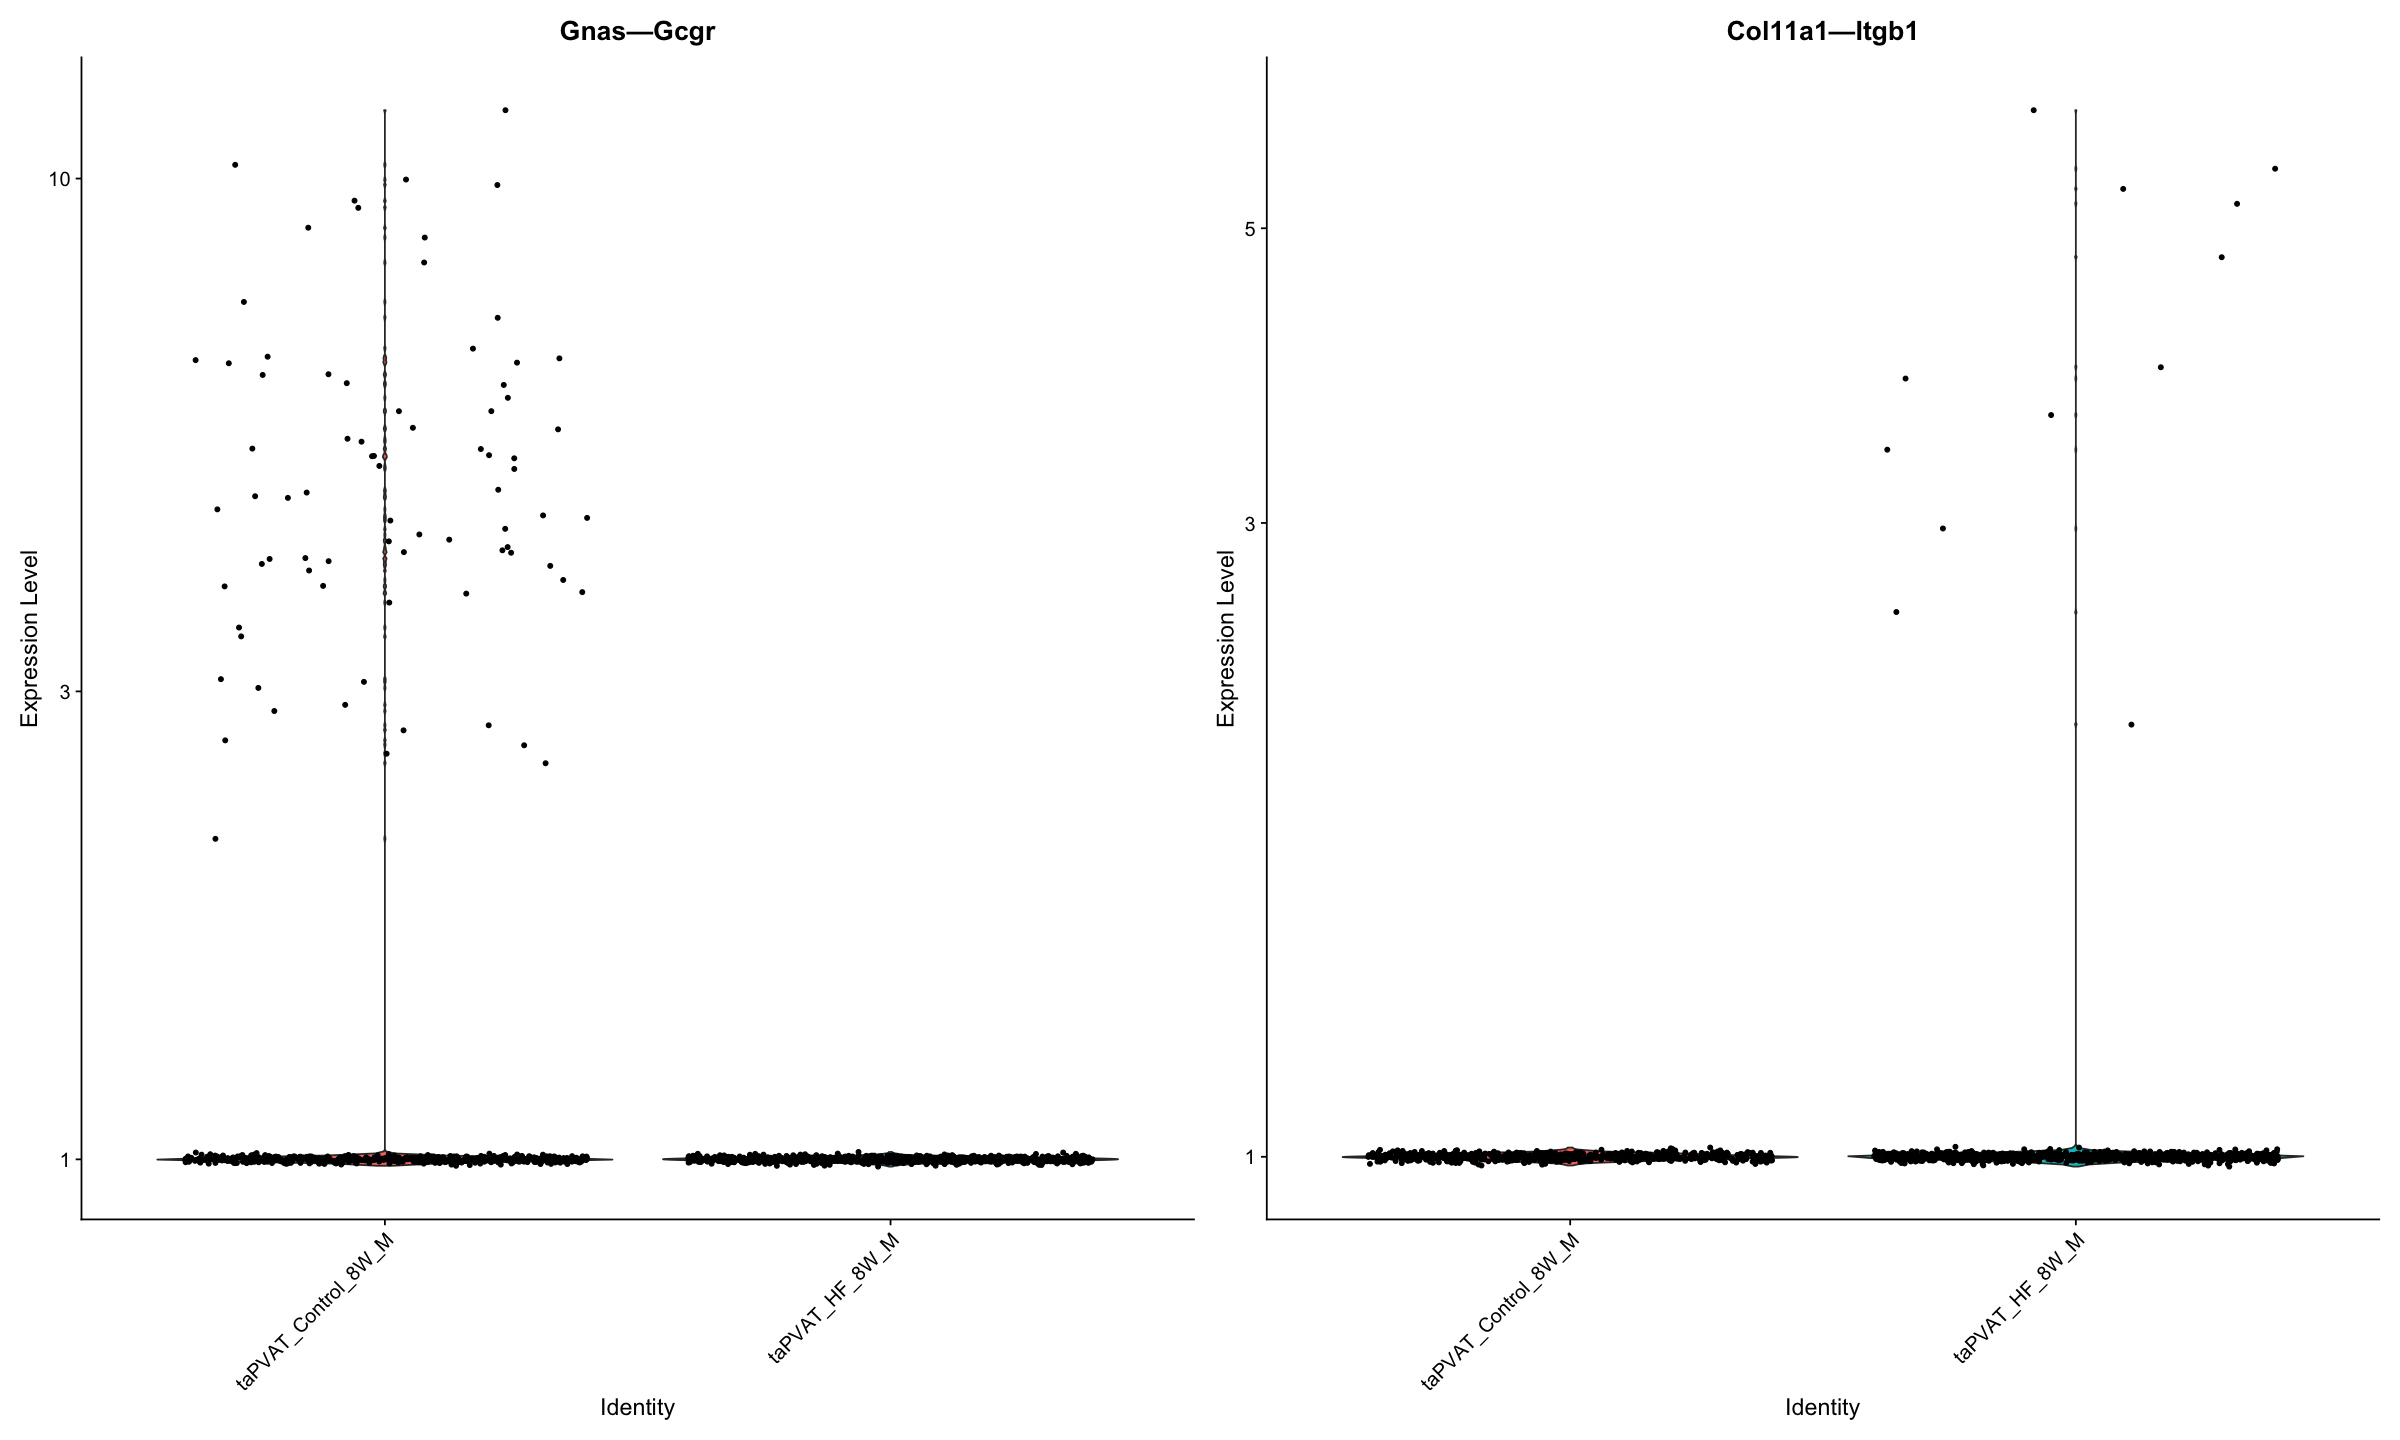